# Importing packages

In [94]:
import os
starting_directory = os.getcwd()
print(os.getcwd())

new_dirrectory = '/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma'
os.chdir(new_dirrectory)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma


In [95]:
import sys
# sys.path.append('/Users/chriskieslich/Box Sync/Research/featureSelection/')

from mistic.svmSet import svmSet
from mistic.cvSet import cvSet 
from mistic.utility import combined_rank, kernelWrapper, score_svc, perDiff, paramSet

import matplotlib.pyplot as plt   
import numpy as np
import pandas as pd
import copy

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

In [96]:
#some functions I wrote to help with exporting data
def outputToExcel(df_data, fileName_header, fileName_Common, fileName_suffix,
                  parent_dir, folderName, sheetName):
    fileName = fileName_header + fileName_Common + fileName_suffix
    outfile_extension = '.xlsx'
    outfile_boxplts = fileName + outfile_extension
    path_out= os.path.join(parent_dir, folderName, outfile_boxplts)

    if os.path.exists(path_out):
            #if old sheet
            with pd.ExcelWriter(path_out, mode = 'a', if_sheet_exists = 'overlay') as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True)
    else: 
            #new sheet
            with pd.ExcelWriter(path_out) as writer:
                    df_data.to_excel(writer, sheet_name = sheetName, index = True) #if new sheet
    
def outputFiguresPath(fileName_header, fileName_mid, fileName_suff, parent_dir, folderName):
        fileName_header = str(fileName_header)
        fileName_mid = str(fileName_mid)
        fileName_suff = str(fileName_suff)

        #cleaning the input to prevent addition of / to the directory
        fileName_header = fileName_header.replace("/", "-")
        fileName_mid = fileName_mid.replace("/", "-")
        fileName_suff = fileName_suff.replace("/", "-")

        fileName = fileName_header + fileName_mid +fileName_suff
        out_filename = fileName + '.tif'
        new_filepath = os.path.join(parent_dir, folderName, out_filename)
        #the output path can be used to save the figure
        return new_filepath
        # plt.savefig(new_filepath, bbox_inches = 'tight')

def makeFolderPathForData(parent_dir, folderName_header, folderName_common, folderName_suffix):
    #makes a new directory for your files
    #returns the folder name for use in other functions
    folderName = folderName_header + folderName_common + folderName_suffix
    path = os.path.join(parent_dir,folderName)
    if not os.path.exists(path):
        os.mkdir(path)
    return folderName

# directory management

In [97]:
# this is written to work out of the blue folder on hpg 

#for file outputs
fileName_header = "SVM_linear_" #what data did you put in
fileName_common = "DescFits_clinSplit_second_red025_" #what was performed on the data, for figures, this may be added to
fileName_suffix = "_250523_v1" #date and versioning

saving_dirrectory = os.path.join("012 Processed Data","019_clinicalSplit", "SecondFeatRed")
if not os.path.exists(saving_dirrectory):
    os.mkdir(saving_dirrectory)
    
makingFolder = makeFolderPathForData(parent_dir = saving_dirrectory, 
                                     folderName_header = "SVM_linear_DescFits_clinSplit_second_red025_", 
                                     folderName_common= "250523_", 
                                     folderName_suffix = "v1")

dataFrameFolderOut =  makingFolder #"SVM_Mistic_Output_2024-07-19_v2"
pickleFolderOut = makingFolder

figDirectory = os.path.join("012 Processed Data","019_clinicalSplit")
figFolder = makingFolder 


In [98]:
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

In [99]:
#parameters of SVM 
red_factor = 0

#cross validation and splitting 
test_size_numb = 1/5
numb_sets = 5

# rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.50, 0.55, 0.6, 0.75, 0.9, 1]
rank_weights = [0, 0.15, 0.2, 0.25, 0.3, 0.4, 0.50, 0.6, 0.75, 0.9, 1]


#random seed 
randomSeed = 0

In [100]:
# test set patients selected 1/5 from the sorted mean KPS scores for the CA+ and CA- subgroups of all patients
testSetPatients = ['T-01', 'B-02', 'I-01', 'Y-02', 'F-03', 'B-03', 'F-01', 'G-03', 'Q-01', 'C-01']
trainSetPatients = ['C-03', 'E-01', 'E-02', 'G-02', 'I-03', 'J-02', 'K-02', 'M-02', 'N-03', 'O-03', 'Q-02', 'Q-03', 'V-02', 'W-01', 'X-01', 'X-02',
                    'A-02', 'C-02', 'E-03', 'H-01', 'H-02', 'M-01', 'N-01', 'N-02', 'P-01', 'P-02', 'R-01', 'R-03', 'S-02', 'T-02', 'V-01', 'W-02', 'Y-01', 'Z-01']

# importing our data

In [101]:
dataFileName = "DF_SVM_noNotes_t-60_DescFits_sk__20250506_v1.xlsx"

In [102]:
# "C:\Users\maega\UFL Dropbox\Maegan Cremer\research-share\Maegan\Projects\Cardiac-Amyloidosis-Multiple-Myeloma\015_Mistic2025\DFsForSVM_noNotes_t-60__20250506_v1\DF_SVM_noNotes_t-60_DescFits_sk__20250506_v1.xlsx"

In [103]:
#file for the feature list
priorFeaturesName = 'SVM_model_comparison_ClinicalSplit.xlsx'
#sheets with prior selected features for this same starting feature list "feature selection"
#header rows 2, 'model' , 'feature reduction', in column 0
priorFeatures_df = pd.read_excel(priorFeaturesName, sheet_name='best feats', header = [0,1]) #data set we are using
priorModel = 'DescFits' #original data conditions
priorFeatureRed = 0.25 #feature reduction rate

priorFeaturesList = list(priorFeatures_df[priorModel, priorFeatureRed].dropna())

x_columns_toKeep = priorFeaturesList #features to use in the initial feature list

This data set contains descriptive statistics, linear and exponential fits, and demographic information for patients with known cardiac amyloidosis status.  The fits were performed using sklearn linear regression.  No physician note data was included in the dataset. Time was restricted to 60 days prior to oncologic diagnosis through all positive time points.

In [104]:
# Import dataset
dataTable = pd.read_excel(dataFileName, sheet_name = "knownPts", header = 0) #the dataset we are using

dataTable.index = dataTable['DeID']

#columns to drop from the x data (samples and features)
x_columns_toDrop = ['DeID', 'CA_status_yes']

#columns to use for the y data 
y_column_Classification = 'CA_status_yes'

X = dataTable.copy()
X.drop(columns=x_columns_toDrop,inplace=True)
x_columns_Compare = [feature for feature in x_columns_toKeep if feature in X.columns]
X = X[x_columns_Compare]

binary_feats = []
for col in X.columns:
    unique_values = X[col].unique()
    if len(unique_values) == 2:
        binary_feats.append(X.columns.get_loc(col))
X.iloc[:,binary_feats]    

Empty DataFrame
Columns: []
Index: [B-02, C-03, E-01, E-02, F-03, G-02, I-01, I-03, J-02, K-02, M-02, N-03, O-03, Q-02, Q-03, T-01, V-02, W-01, X-01, X-02, Y-02, A-02, B-03, C-01, C-02, E-03, F-01, G-03, H-01, H-02, M-01, N-01, N-02, P-01, P-02, Q-01, R-01, R-03, S-02, T-02, V-01, W-02, Y-01, Z-01]

In [105]:
# #finding the index for the test and train patients 
# IndexTestPatients = dataTable[testSetPatients].index()
# IndexTrainPatients = dataTable[trainSetPatients].index()

# Setting up classifier

## Scaling data and defining test set

In [106]:
scaler = StandardScaler().set_output(transform = 'pandas')
scaler.fit(X)

X_all = scaler.transform(X)
y_all = dataTable[y_column_Classification]

# X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
#                                                     stratify = y_all, 
#                                                     random_state= randomSeed, 
#                                                     test_size= test_size_numb)

X_train = X_all.loc[trainSetPatients]
y_train = y_all.loc[trainSetPatients]
X_test = X_all.loc[testSetPatients]
y_test = y_all.loc[testSetPatients]

# max(X_all[:,0])
X_all.max().max()

5.897954065894661

In [107]:
outputToExcel(df_data=dataTable.loc[trainSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "train_data")
outputToExcel(df_data=dataTable.loc[testSetPatients], fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "test_data")

## define cross validation

In [108]:
#convert everything to numpy arrays to get the rest to run 
X_train = X_train.to_numpy()
# y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
# y_test = y_test.to_numpy()
X_all = X_all.to_numpy()

In [109]:
cv_set = cvSet(X = X_train, y = y_train.values)
cv_set.classification(num_sets = numb_sets)

## initiallize SVC and parameter grids

In [110]:
svc = SVC(kernel = 'precomputed', class_weight="balanced", probability=False, tol = 1e-10)

C_range = [2**x for x in range(-8,5)]

kernel_type = "linear"

parameter_grid = []
for cost in C_range:
    parameter_grid.append(paramSet(model={"C": cost},kernel={}))

test = svmSet(svc, cv_set,
              score_method = score_svc().score,
              kernel = kernelWrapper(type = kernel_type),
              separate_parameters = False)

test.tune_models(parameter_grid)
test.performance_ 

{'f1': 0.96,
 'auc': 0.9777777777777779,
 'score': 0.968888888888889,
 'C': 0.03125}

In [111]:
test_y_predict = test.predict(X_test)
decision_values = test.decision_function(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, test_y_predict).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 
                       'false neg': fn, 'true pos': tp,
                       'precision or PPV': precision, 
                       'recall or TPR': recall, 'specificity or TNR': specificity}
dict_temp_blindpred


{'f1': 0.8000000000000002,
 'auc': 0.92,
 'true neg': 4,
 'false pos': 1,
 'false neg': 1,
 'true pos': 4,
 'precision or PPV': 0.8,
 'recall or TPR': 0.8,
 'specificity or TNR': 0.8}

# alternative models

In [112]:
# alternative models

In [113]:
# first testing other models for comparison

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

In [114]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train, y_train)
y_pred = rnd_clf.predict(X_test)
print( "ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns)
# fig, ax = plt.subplots()
# forest_importances.plot.bar(ax=ax)
# fig.tight_layout()

ROC:  0.8
F1:  0.8


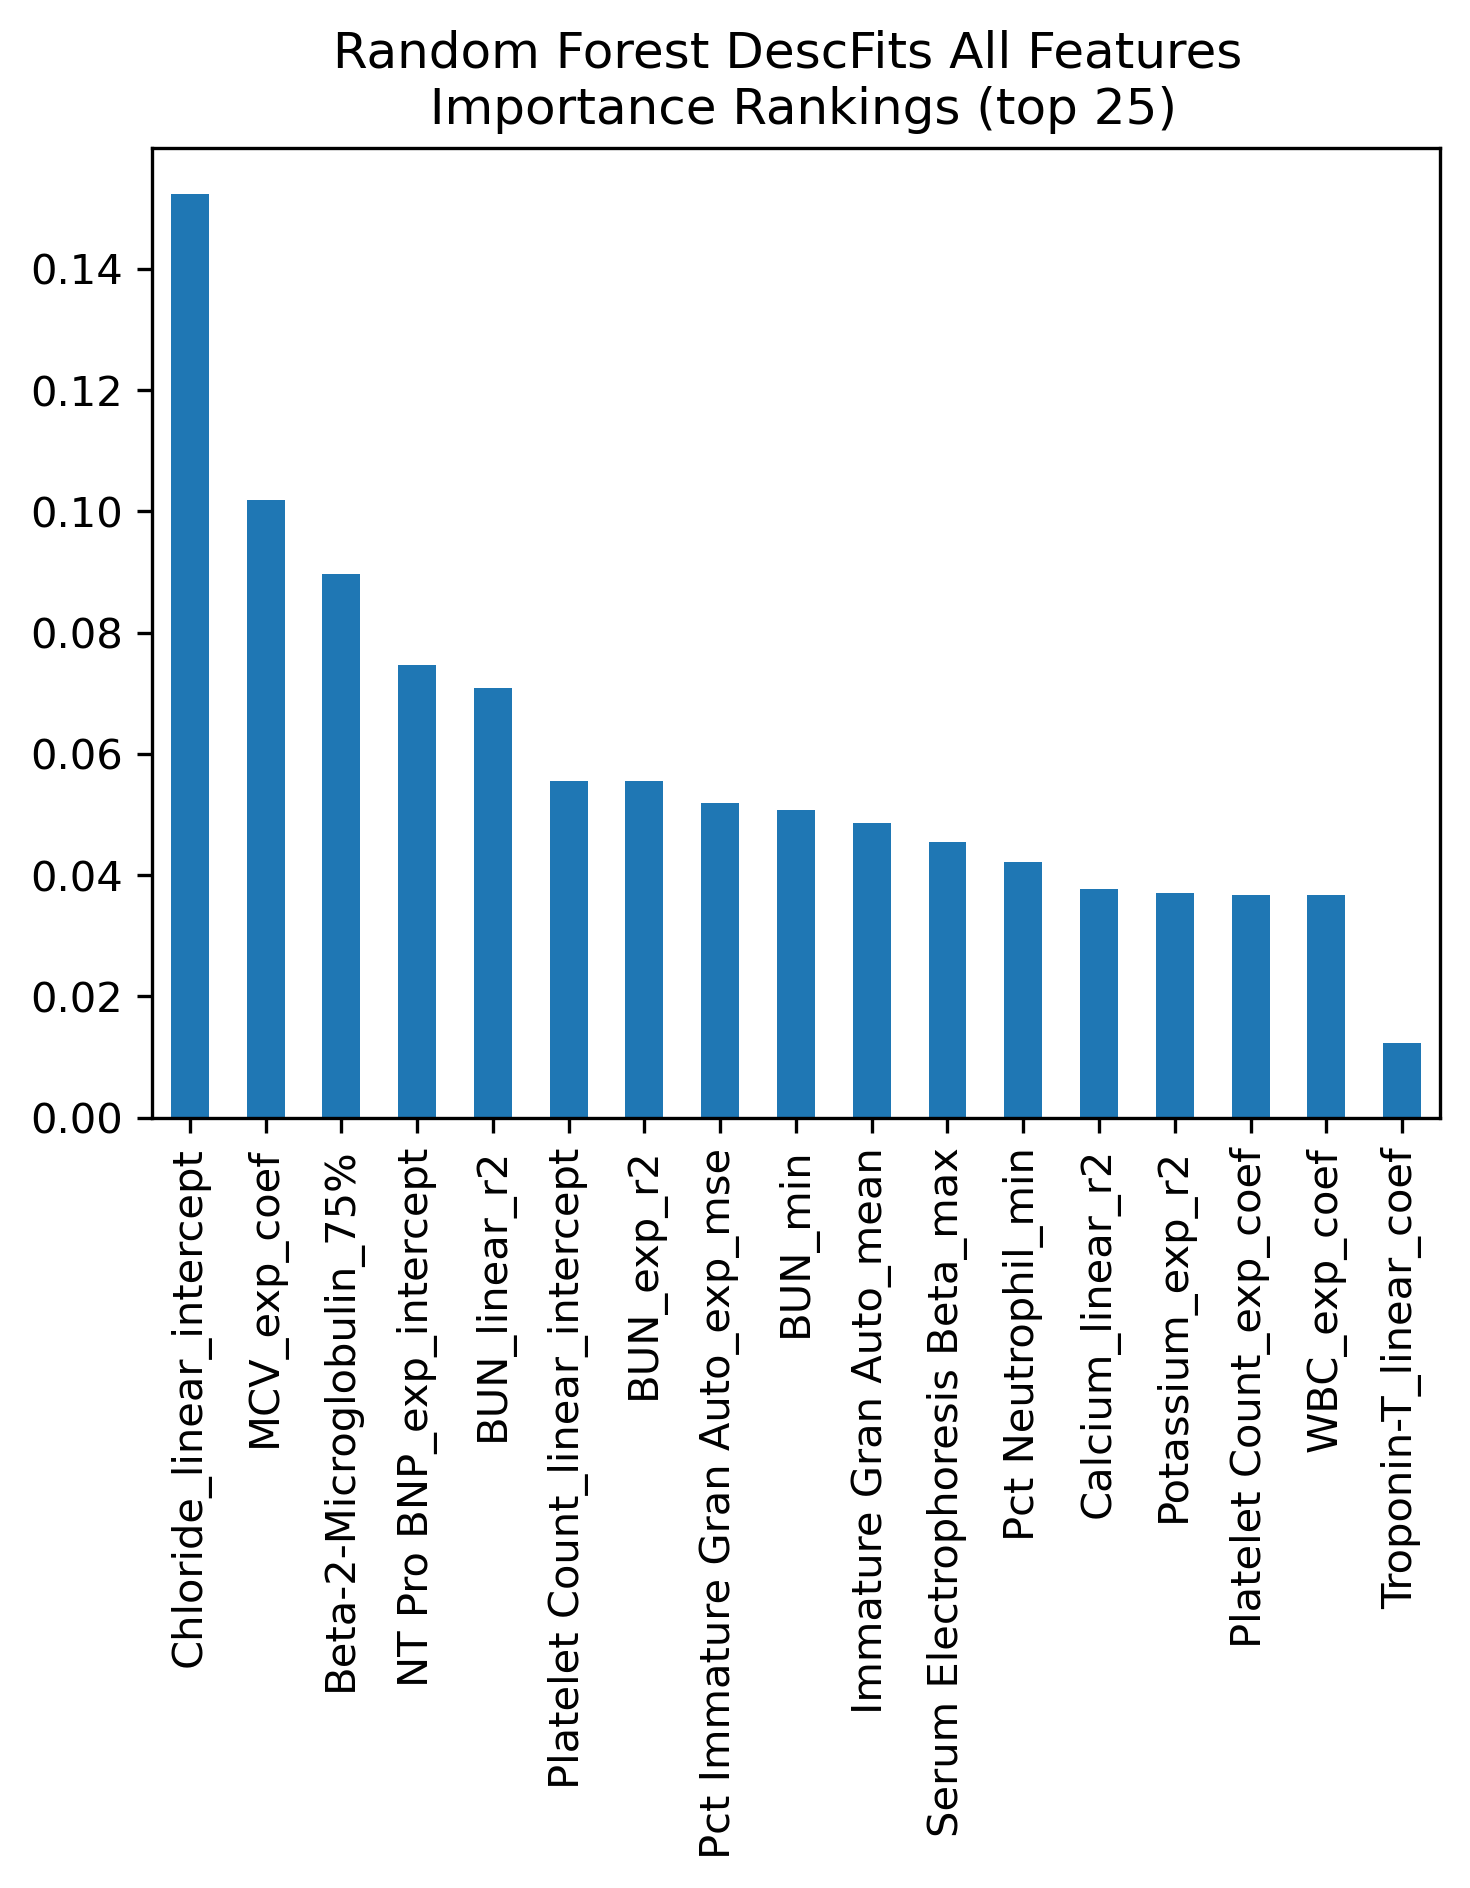

In [115]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = forest_importances.sort_values(ascending=False).head(25)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest DescFits All Features \n Importance Rankings (top 25)")

# Show the plot
plt.show()

In [161]:
what_train = pd.DataFrame(X_train, columns = X.columns) 
what_test = pd.DataFrame(X_test, columns = X.columns) 

In [162]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(what_train[list(top_20_importances.index[:4])], y_train)
y_pred = rnd_clf.predict(what_test[list(top_20_importances.index[:4])])

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print( "ROC: ", roc_auc_score(y_test, y_pred))
importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= what_train[list(top_20_importances.index[:4])].columns)

F1:  0.6666666666666666
ROC:  0.7000000000000002


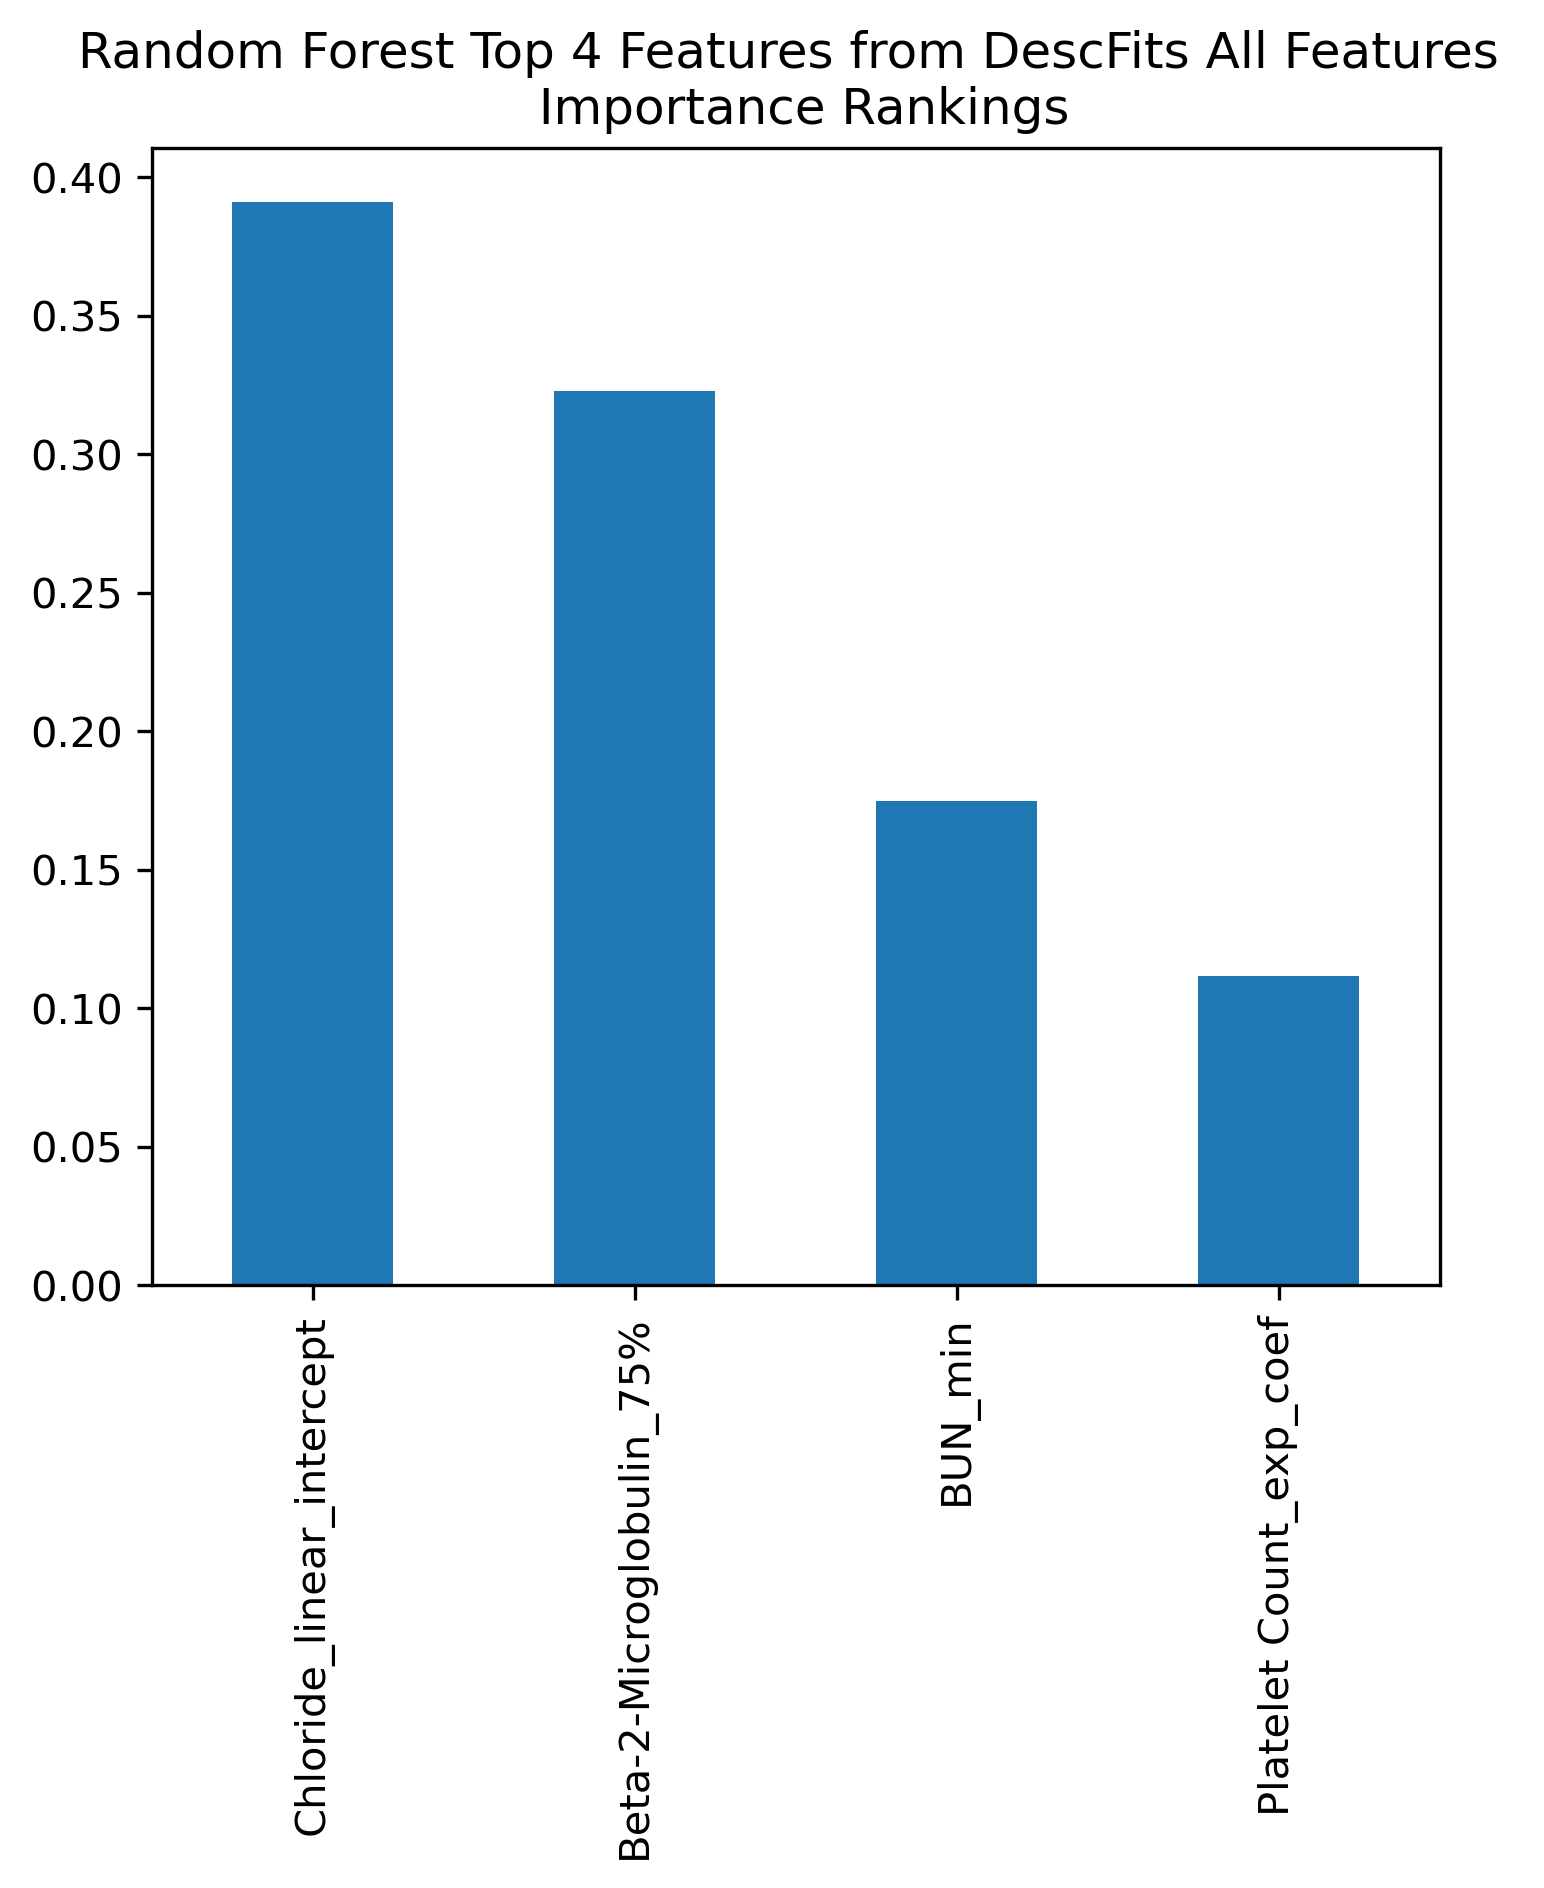

In [163]:
# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.sort_values(ascending=False).plot.bar(ax=ax)
fig.tight_layout()
ax.set_title("Random Forest Top 4 Features from DescFits All Features \n Importance Rankings")

# Show the plot
plt.show()

In [119]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns)
# fig, ax = plt.subplots()
# xgb_importances.plot.bar(ax=ax)
# ax.set_title("XGBoost All Features Importance Rankings")
# fig.tight_layout()

ROC:  0.7000000000000001
F1:  0.7272727272727273


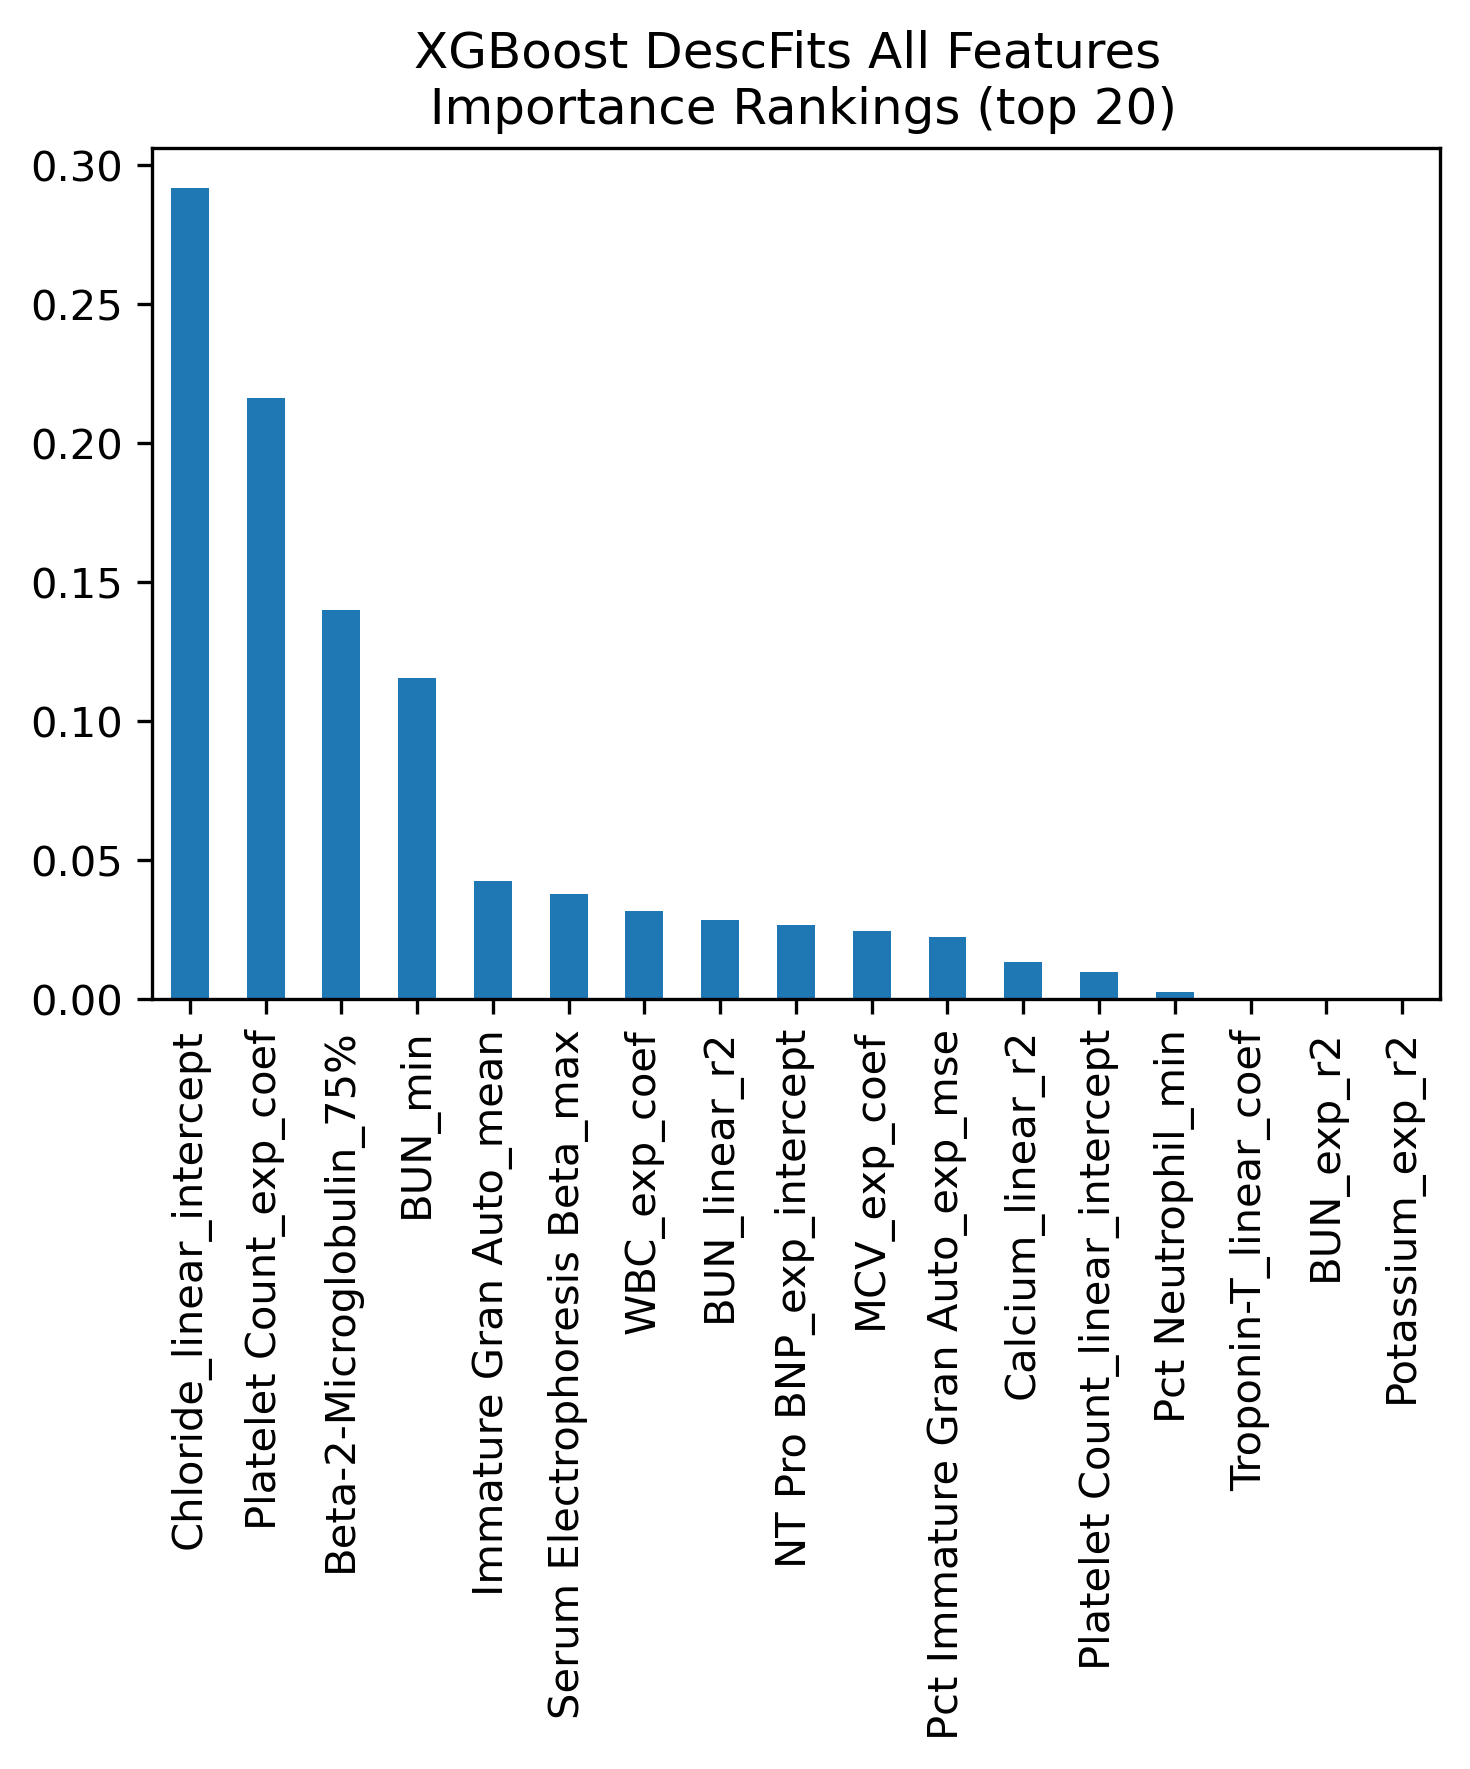

In [120]:
# Sort the importances in descending order and select the top 20 features
top_20_importances = xgb_importances.sort_values(ascending=False).head(20)

# Plotting the bar chart for the top 20 features
fig, ax = plt.subplots(figsize = (5,6))
top_20_importances.plot.bar(ax=ax)
ax.set_title("XGBoost DescFits All Features \n Importance Rankings (top 20)")
fig.tight_layout()

# Show the plot
plt.show()

In [121]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_test)
# lgb_clf.predict_proba(X_test)
print("ROC: ", roc_auc_score(y_test, y_pred))
print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Warning] No furt

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



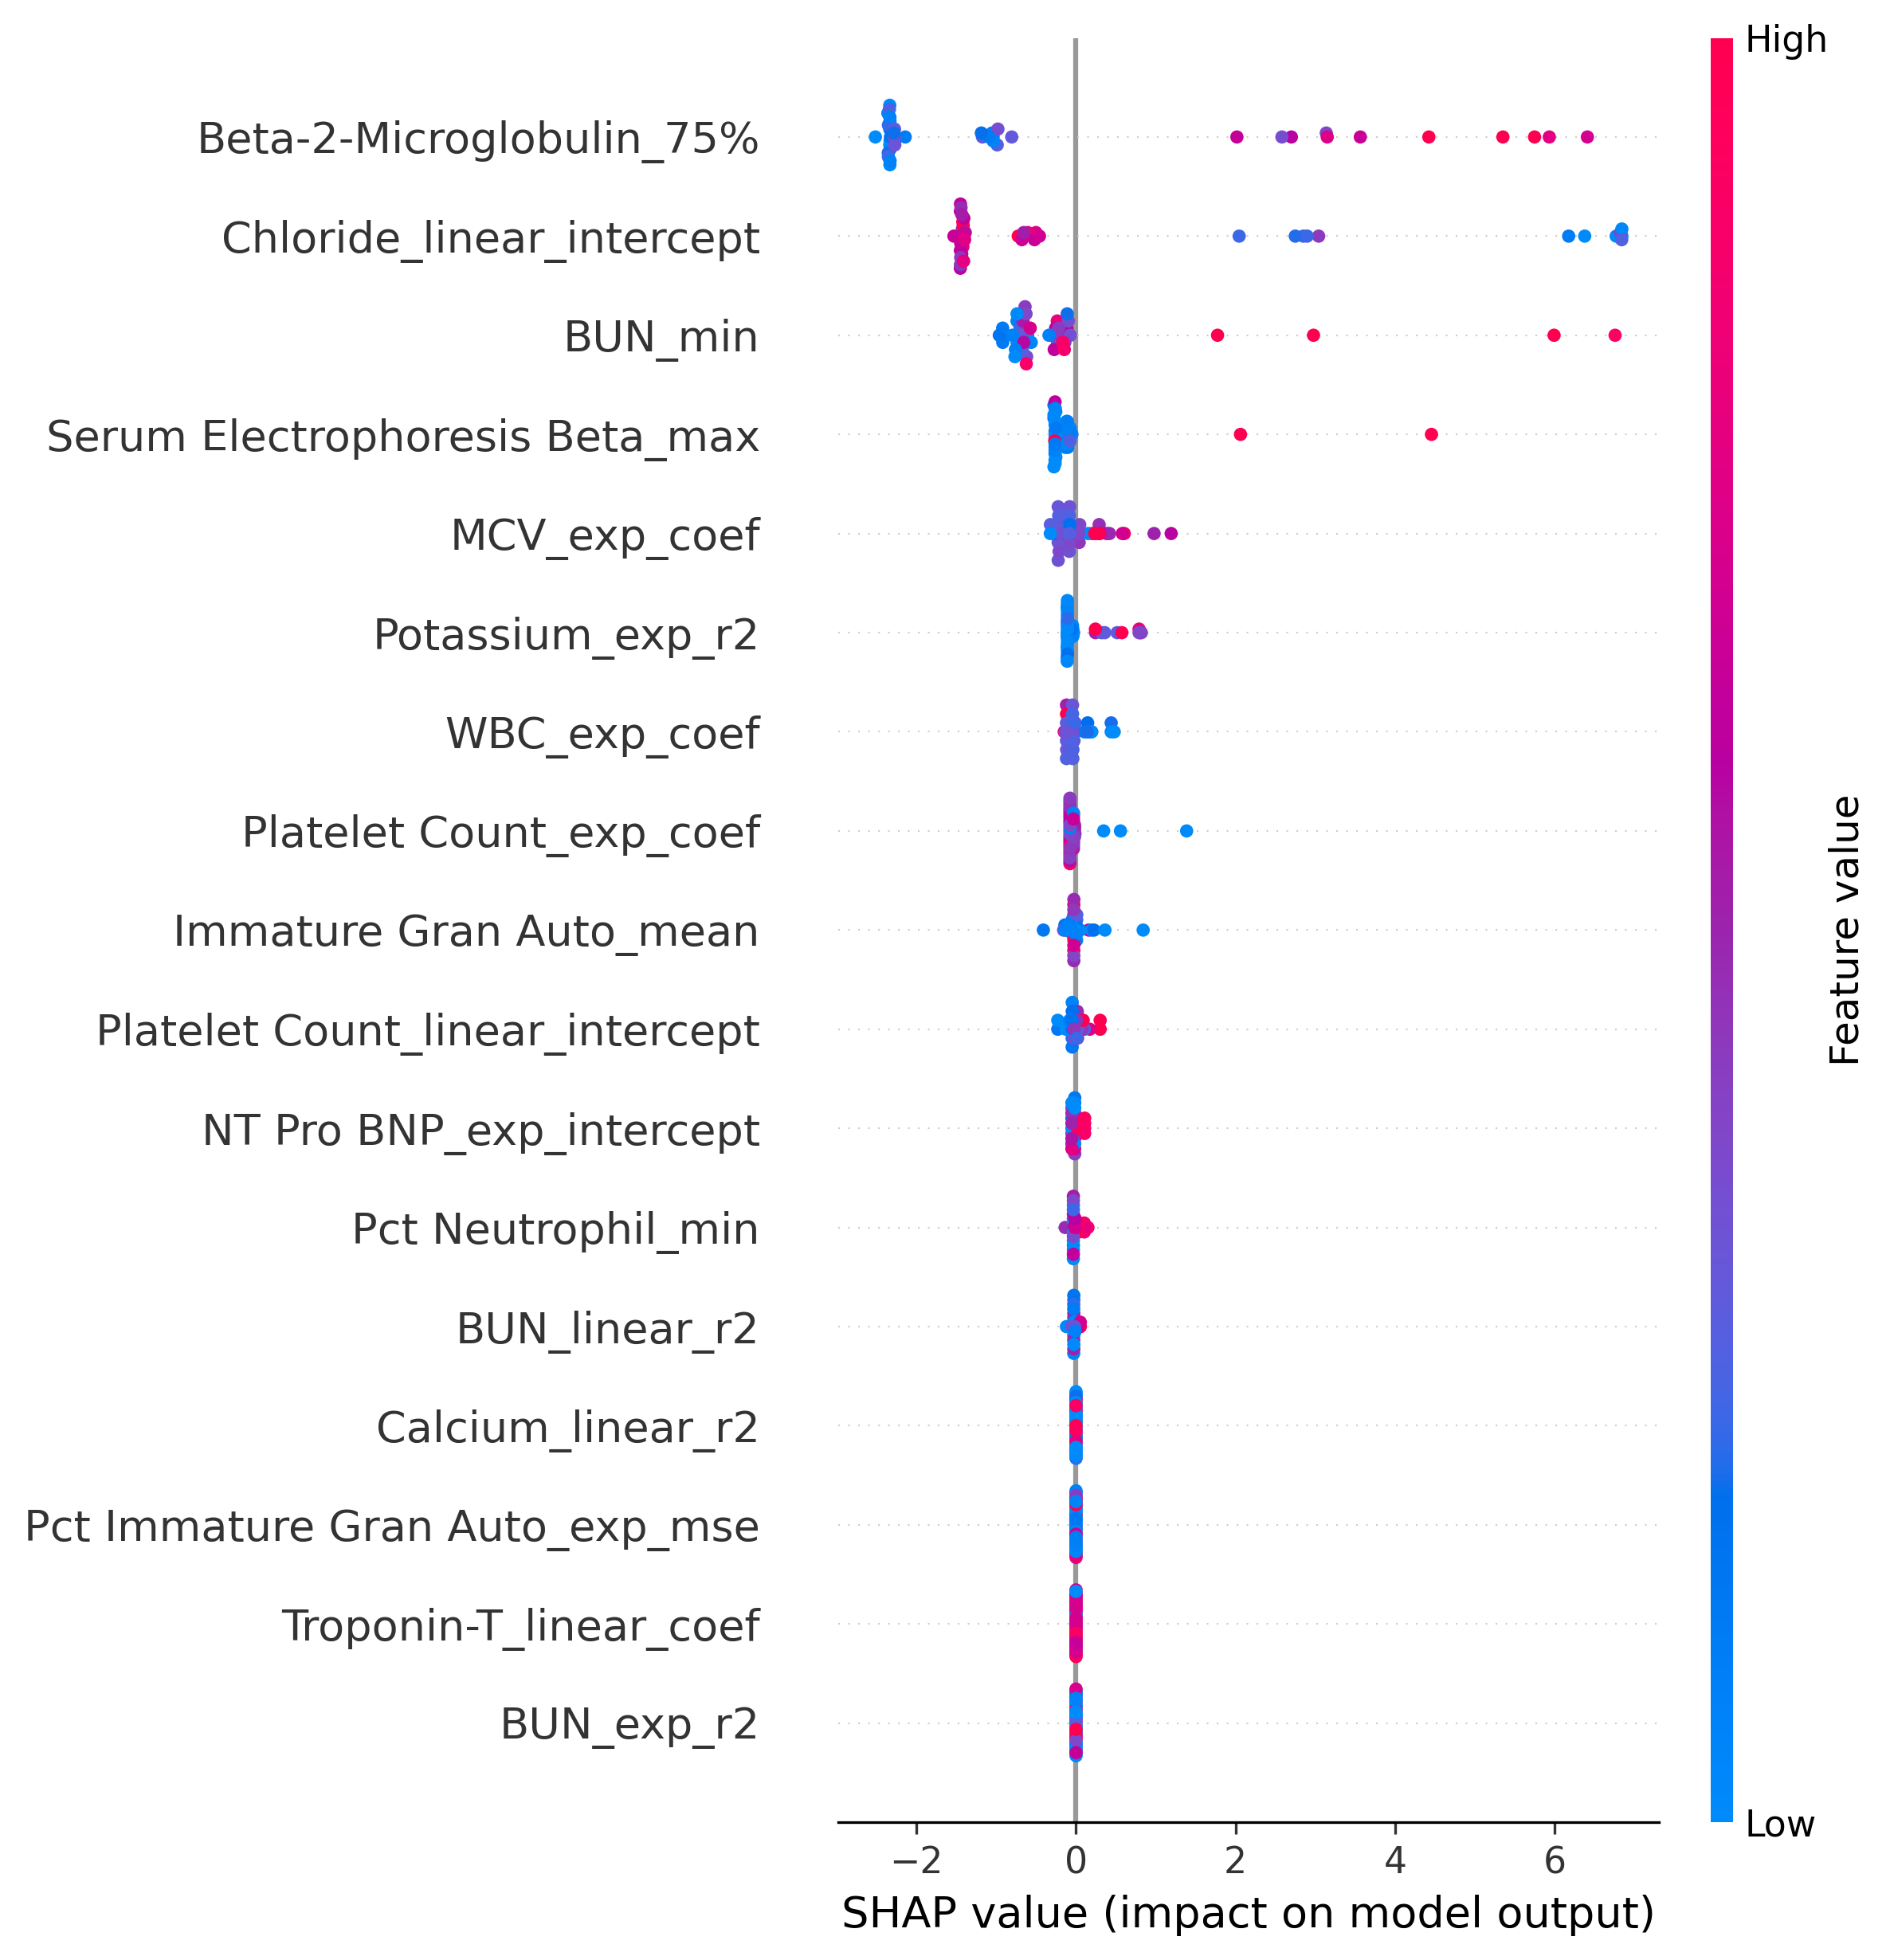

In [122]:
import shap
#borrowed from online source and edited
# create explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all)

shap.summary_plot(shap_values, X_all, feature_names = X.columns)


# bar plot for feature importances
# shap.summary_plot(shap_values_reshaped[1], X_test, plot_type="bar")

# Show the plot
plt.show()

# feature selection

In [123]:
svm_set_ranks = []
for i in range(len(rank_weights)):
    print(f"Rank weight: {rank_weights[i]:.2f}")
    svm_set_ranks.append(svmSet(svc, cv_set,
                                score_method = score_svc().score,
                                kernel = kernelWrapper(type = kernel_type),
                                separate_feature_sets = False,
                                separate_parameters = False,
                                sparse_kernel_matrix = False))

    svm_set_ranks[i].greedy_backward_selection(parameter_grid = parameter_grid,
                                           reduction_factor = red_factor,
                                           feature_ranker = combined_rank(weight=rank_weights[i]).compute,
                                           set_for_rank = "sample")

Rank weight: 0.00
Number of Features: 17, Score: 0.969
Number of Features: 16, Score: 0.939
Number of Features: 15, Score: 0.928
Number of Features: 14, Score: 0.941
Number of Features: 13, Score: 0.902
Number of Features: 12, Score: 0.849
Number of Features: 11, Score: 0.852
Number of Features: 10, Score: 0.866
Number of Features: 9, Score: 0.860
Number of Features: 8, Score: 0.880
Number of Features: 7, Score: 0.793
Number of Features: 6, Score: 0.721
Number of Features: 5, Score: 0.717
Number of Features: 4, Score: 0.600
Number of Features: 3, Score: 0.653
Number of Features: 2, Score: 0.524
Number of Features: 1, Score: 0.589
Rank weight: 0.15
Number of Features: 17, Score: 0.969
Number of Features: 16, Score: 0.939
Number of Features: 15, Score: 0.928
Number of Features: 14, Score: 0.941
Number of Features: 13, Score: 0.902
Number of Features: 12, Score: 0.849
Number of Features: 11, Score: 0.850
Number of Features: 10, Score: 0.869
Number of Features: 9, Score: 0.828
Number of Fe

# Performance plots

## F1 and AUC plots

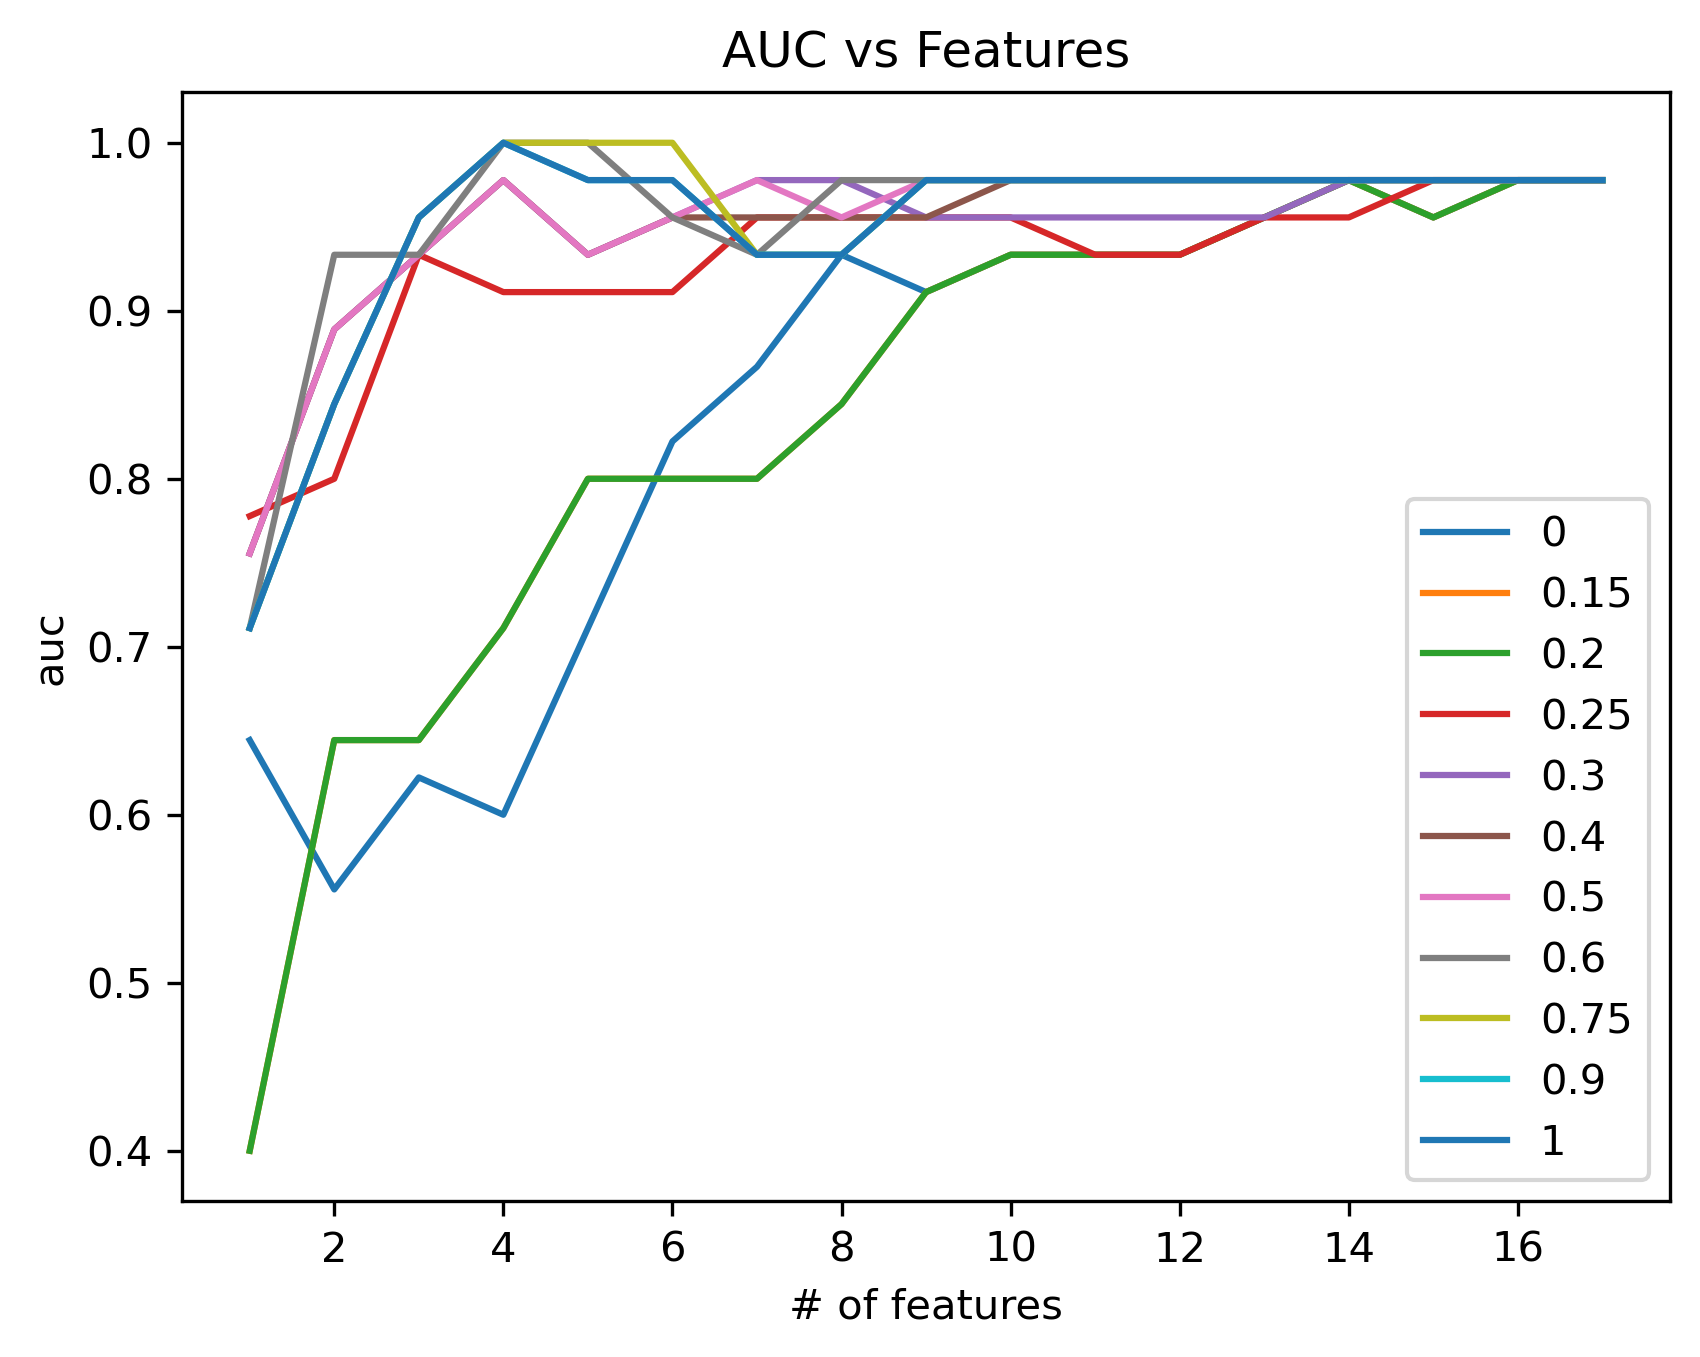

In [124]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="auc")

plt.legend(labels=rank_weights)
ax.set_title("AUC vs Features")

#saving figure
figCommon = fileName_common + "_AUC"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

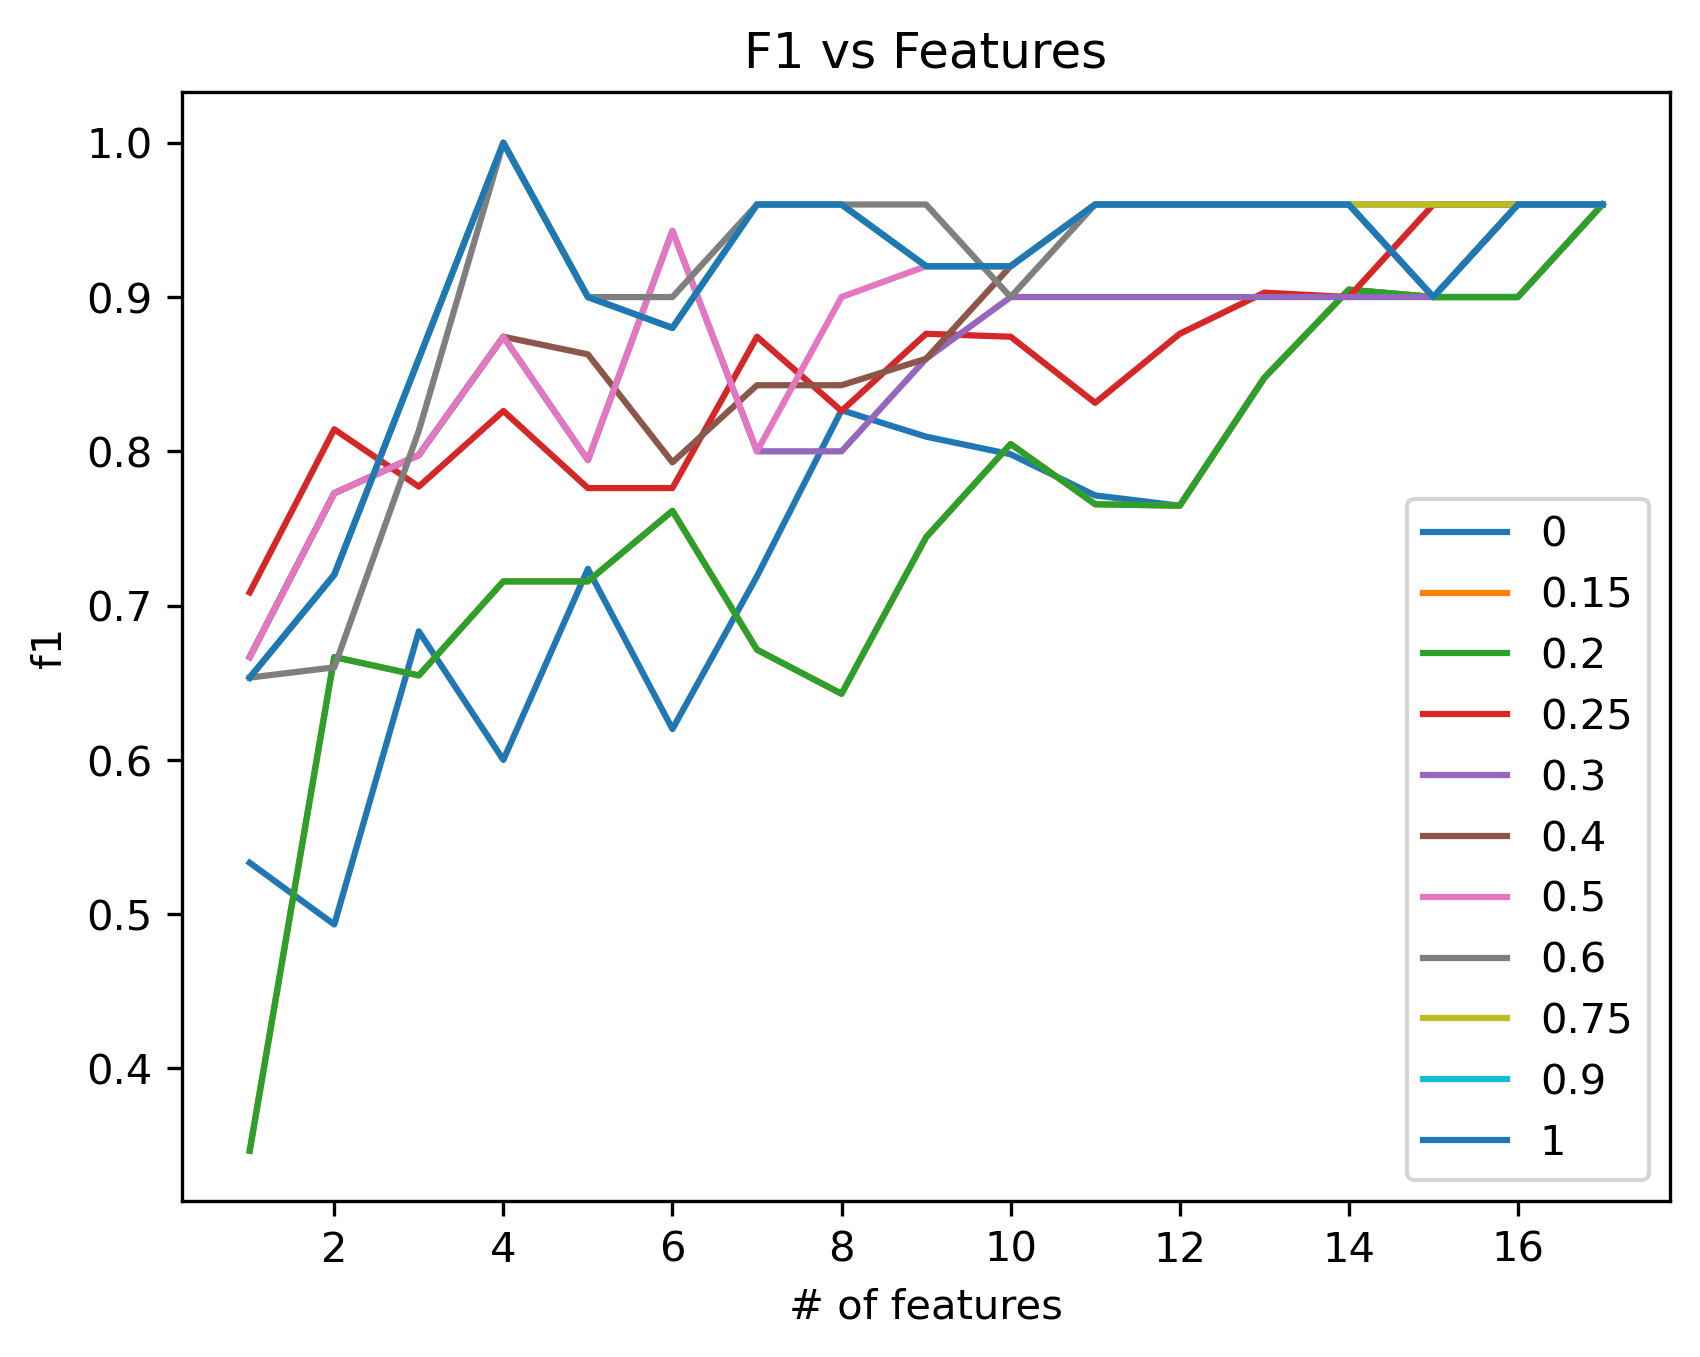

In [125]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="f1")

plt.legend(labels=rank_weights)
ax.set_title("F1 vs Features")

#saving figure
figCommon = fileName_common + "_F1"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

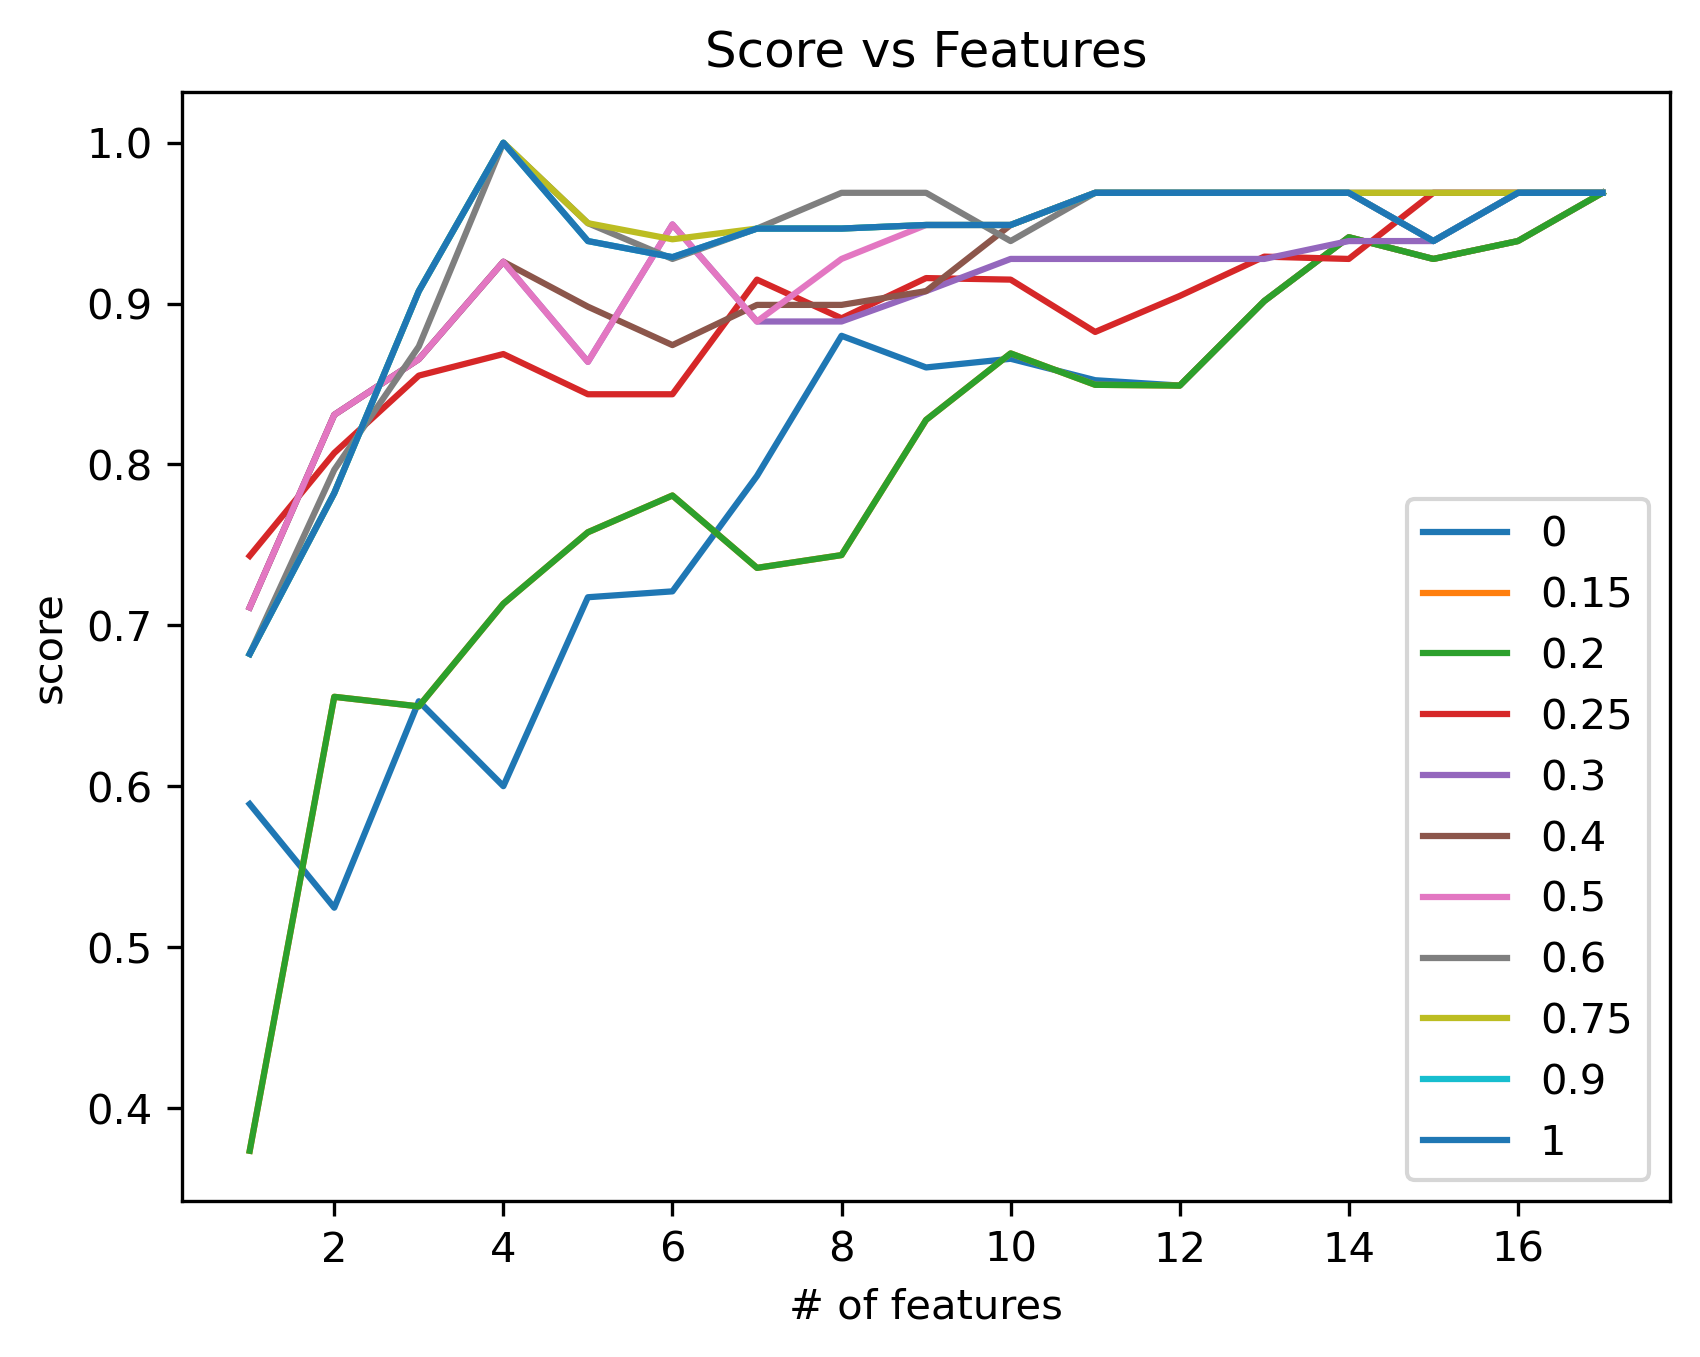

In [126]:
fig, ax = plt.subplots()

for i in range(len(rank_weights)):
    svm_set_ranks[i].plot_performance(metric="score")

plt.legend(labels=rank_weights)
ax.set_title("Score vs Features")

#saving figure
figCommon = fileName_common + "_Score"
figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

# picking best model 

enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "max"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

In [127]:
enrich_score = []
for i in range(len(rank_weights)):
    enrich_score.append(svm_set_ranks[i].enrichment_score(type = "auc"))

#selected_run = 4
selected_run = enrich_score.index(max(enrich_score))

enrich_score

[0.7532072829131654,
 0.7536741363211952,
 0.7536741363211952,
 0.8407563025210085,
 0.8540429505135387,
 0.86312324929972,
 0.8690102707749767,
 0.8829411764705883,
 0.8829411764705883,
 0.8798692810457518,
 0.8798692810457518]

In [128]:
svm_set_ranks[selected_run].performance_

{'f1': 1.0,
 'auc': 1.0,
 'score': 1.0,
 'C': 8,
 'num_features': 4,
 'mean_nSV': 5.4}

In [129]:
score_list = []

for i in range(len(rank_weights)):
    score_list.append(svm_set_ranks[i].performance_['score'])

maxScore = max(score_list)
topModelIndex = score_list.index(maxScore)


In [130]:
#saving the feature ranking, performance, and model evaluations to spreadsheets

for i in range(len(rank_weights)):
    #collecting the performance as a dataframe
    df_bestPerformance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index')
    outputToExcel(df_data=df_bestPerformance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".", "") + "_best model perf")


    df_bestFeatures= pd.DataFrame(list(X.columns[svm_set_ranks[i].features]))
    #saving the best features
    outputToExcel(df_data=df_bestFeatures, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
                folderName= dataFrameFolderOut, sheetName= str(rank_weights[i]).replace(".","") + "_features")




In [131]:
iterator = 1
for i in range(len(rank_weights)):
    if iterator == 1:
        #create the df_performance and collect the performance information
        df_performance = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T

        #create feature list dataframe 
        df_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        iterator = iterator + 1 #to increment
    else:
        #collect the data and add it to the existing frames
        df_temp_perf = pd.DataFrame.from_dict(svm_set_ranks[i].performance_, orient = 'index', columns = [str(rank_weights[i])]).T
        df_temp_features = pd.DataFrame(list(X.columns[svm_set_ranks[i].features]), columns=[str(rank_weights[i])])
        #concatinate with pervious
        df_performance = pd.concat([df_performance, df_temp_perf], axis =0)
        df_features = pd.concat([df_features, df_temp_features], axis = 1)
        iterator = iterator + 1

#saving the features and performance
outputToExcel(df_data=df_performance, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_best model perf")

outputToExcel(df_data=df_features, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_features")

iterator = 1
dict_blindprediction = {} #index is the weight
for i in range(len(rank_weights)):
    decision_values = svm_set_ranks[i].decision_function(X_test)
    y_pred = svm_set_ranks[i].predict(X_test)

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    specificity = tn/(tn + fp)
    f1 = 2*precision*recall/(precision+recall)
    auc = roc_auc_score(y_test, decision_values)

    dict_temp_blindpred = {"f1": f1, 'auc': auc, 'true neg': tn, 'false pos': fp, 'false neg': fn, 'true pos': tp,
                           'precision or PPV': precision, 'recall or TPR': recall, 'specificity or TNR': specificity}
    if iterator == 1:
        df_blindprediction = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        iterator = iterator +1
    else:
        df_temp_blindpred = pd.DataFrame.from_dict(data = dict_temp_blindpred, orient = 'index', columns = [str(rank_weights[i])]).T
        df_blindprediction = pd.concat([df_blindprediction, df_temp_blindpred], axis = 0)
        iterator = iterator + 1
    # print(df_temp_blindpred)
    # dict_blindprediction[str(rank_weights[i])] = df_temp_blindpred

# df_blindprediction = pd.DataFrame.from_dict(dict_blindprediction, orient= 'index')
outputToExcel(df_data=df_blindprediction, fileName_header=fileName_header, fileName_Common=fileName_common, fileName_suffix=fileName_suffix, parent_dir=saving_dirrectory,
            folderName= dataFrameFolderOut, sheetName= "concat_blindprediction")


In [132]:
df_blindprediction

f1   auc  true neg  false pos  false neg  true pos  \
0     0.800000  0.92       4.0        1.0        1.0       4.0   
0.15  0.800000  0.92       4.0        1.0        1.0       4.0   
0.2   0.800000  0.92       4.0        1.0        1.0       4.0   
0.25  0.800000  0.92       4.0        1.0        1.0       4.0   
0.3   0.800000  0.92       4.0        1.0        1.0       4.0   
0.4   0.800000  0.92       4.0        1.0        1.0       4.0   
0.5   0.800000  0.92       4.0        1.0        1.0       4.0   
0.6   0.666667  0.88       4.0        1.0        2.0       3.0   
0.75  0.666667  0.88       4.0        1.0        2.0       3.0   
0.9   0.666667  0.88       4.0        1.0        2.0       3.0   
1     0.666667  0.88       4.0        1.0        2.0       3.0   

      precision or PPV  recall or TPR  specificity or TNR  
0                 0.80            0.8                 0.8  
0.15              0.80            0.8                 0.8  
0.2               0.80            0.8                 0.8  
0.25              0.80            0.8                 0.8  
0.3               0.80            0.8                 0.8  
0.4               0.80            0.8                 0.8  
0.5               0.80            0.8                 0.8  
0.6               0.75            0.6                 0.8  
0.75              0.75            0.6                 0.8  
0.9               0.75            0.6                 0.8  
1                 0.75            0.6                 0.8

In [133]:
df_performance

f1       auc     score        C  num_features  mean_nSV
0     0.96  0.977778  0.968889  0.03125          17.0      19.4
0.15  0.96  0.977778  0.968889  0.03125          17.0      19.4
0.2   0.96  0.977778  0.968889  0.03125          17.0      19.4
0.25  0.96  0.977778  0.968889  0.03125          15.0      20.6
0.3   0.96  0.977778  0.968889  0.03125          16.0      20.0
0.4   0.96  0.977778  0.968889  0.03125          11.0      21.0
0.5   0.96  0.977778  0.968889  0.03125          11.0      21.0
0.6   1.00  1.000000  1.000000  8.00000           4.0       5.4
0.75  1.00  1.000000  1.000000  8.00000           4.0       5.4
0.9   1.00  1.000000  1.000000  8.00000           4.0       5.4
1     1.00  1.000000  1.000000  8.00000           4.0       5.4

In [134]:
df_features

0                             0.15  \
0                           BUN_min                          BUN_min   
1          Beta-2-Microglobulin_75%         Beta-2-Microglobulin_75%   
2           Immature Gran Auto_mean          Immature Gran Auto_mean   
3                Pct Neutrophil_min               Pct Neutrophil_min   
4    Serum Electrophoresis Beta_max   Serum Electrophoresis Beta_max   
5                     BUN_linear_r2                    BUN_linear_r2   
6                 Calcium_linear_r2                Calcium_linear_r2   
7         Chloride_linear_intercept        Chloride_linear_intercept   
8   Platelet Count_linear_intercept  Platelet Count_linear_intercept   
9            Troponin-T_linear_coef           Troponin-T_linear_coef   
10                       BUN_exp_r2                       BUN_exp_r2   
11                     MCV_exp_coef                     MCV_exp_coef   
12   Pct Immature Gran Auto_exp_mse   Pct Immature Gran Auto_exp_mse   
13          Platelet Count_exp_coef          Platelet Count_exp_coef   
14                 Potassium_exp_r2                 Potassium_exp_r2   
15                     WBC_exp_coef                     WBC_exp_coef   
16         NT Pro BNP_exp_intercept         NT Pro BNP_exp_intercept   

                                0.2                             0.25  \
0                           BUN_min                          BUN_min   
1          Beta-2-Microglobulin_75%         Beta-2-Microglobulin_75%   
2           Immature Gran Auto_mean          Immature Gran Auto_mean   
3                Pct Neutrophil_min               Pct Neutrophil_min   
4    Serum Electrophoresis Beta_max   Serum Electrophoresis Beta_max   
5                     BUN_linear_r2        Chloride_linear_intercept   
6                 Calcium_linear_r2  Platelet Count_linear_intercept   
7         Chloride_linear_intercept           Troponin-T_linear_coef   
8   Platelet Count_linear_intercept                       BUN_exp_r2   
9            Troponin-T_linear_coef                     MCV_exp_coef   
10                       BUN_exp_r2   Pct Immature Gran Auto_exp_mse   
11                     MCV_exp_coef          Platelet Count_exp_coef   
12   Pct Immature Gran Auto_exp_mse                 Potassium_exp_r2   
13          Platelet Count_exp_coef                     WBC_exp_coef   
14                 Potassium_exp_r2         NT Pro BNP_exp_intercept   
15                     WBC_exp_coef                              NaN   
16         NT Pro BNP_exp_intercept                              NaN   

                                0.3                             0.4  \
0                           BUN_min                         BUN_min   
1          Beta-2-Microglobulin_75%        Beta-2-Microglobulin_75%   
2           Immature Gran Auto_mean  Serum Electrophoresis Beta_max   
3                Pct Neutrophil_min                   BUN_linear_r2   
4    Serum Electrophoresis Beta_max       Chloride_linear_intercept   
5                     BUN_linear_r2          Troponin-T_linear_coef   
6         Chloride_linear_intercept                    MCV_exp_coef   
7   Platelet Count_linear_intercept  Pct Immature Gran Auto_exp_mse   
8            Troponin-T_linear_coef         Platelet Count_exp_coef   
9                        BUN_exp_r2                    WBC_exp_coef   
10                     MCV_exp_coef        NT Pro BNP_exp_intercept   
11   Pct Immature Gran Auto_exp_mse                             NaN   
12          Platelet Count_exp_coef                             NaN   
13                 Potassium_exp_r2                             NaN   
14                     WBC_exp_coef                             NaN   
15         NT Pro BNP_exp_intercept                             NaN   
16                              NaN                             NaN   

                               0.5                             0.6  \
0                          BUN_min                         BUN_min   
1         Beta-2-Micr

In [135]:
df_features['0.6'].dropna()

0                           BUN_min
1    Serum Electrophoresis Beta_max
2                     BUN_linear_r2
3         Chloride_linear_intercept
Name: 0.6, dtype: object

In [136]:
df_features['0.3'].dropna()

0                             BUN_min
1            Beta-2-Microglobulin_75%
2             Immature Gran Auto_mean
3                  Pct Neutrophil_min
4      Serum Electrophoresis Beta_max
5                       BUN_linear_r2
6           Chloride_linear_intercept
7     Platelet Count_linear_intercept
8              Troponin-T_linear_coef
9                          BUN_exp_r2
10                       MCV_exp_coef
11     Pct Immature Gran Auto_exp_mse
12            Platelet Count_exp_coef
13                   Potassium_exp_r2
14                       WBC_exp_coef
15           NT Pro BNP_exp_intercept
Name: 0.3, dtype: object

## best model performance

In [137]:
print("rank weights: ", str(rank_weights[selected_run]))
print(df_performance.iloc[selected_run])
print(df_blindprediction.iloc[selected_run])

rank weights:  0.6
f1              1.0
auc             1.0
score           1.0
C               8.0
num_features    4.0
mean_nSV        5.4
Name: 0.6, dtype: float64
f1                    0.666667
auc                   0.880000
true neg              4.000000
false pos             1.000000
false neg             2.000000
true pos              3.000000
precision or PPV      0.750000
recall or TPR         0.600000
specificity or TNR    0.800000
Name: 0.6, dtype: float64


In [138]:
df_features[str(rank_weights[selected_run])].dropna()

0                           BUN_min
1    Serum Electrophoresis Beta_max
2                     BUN_linear_r2
3         Chloride_linear_intercept
Name: 0.6, dtype: object

## pair plots

Text(0.5, 1.08, 'Rank weight: 0.60')

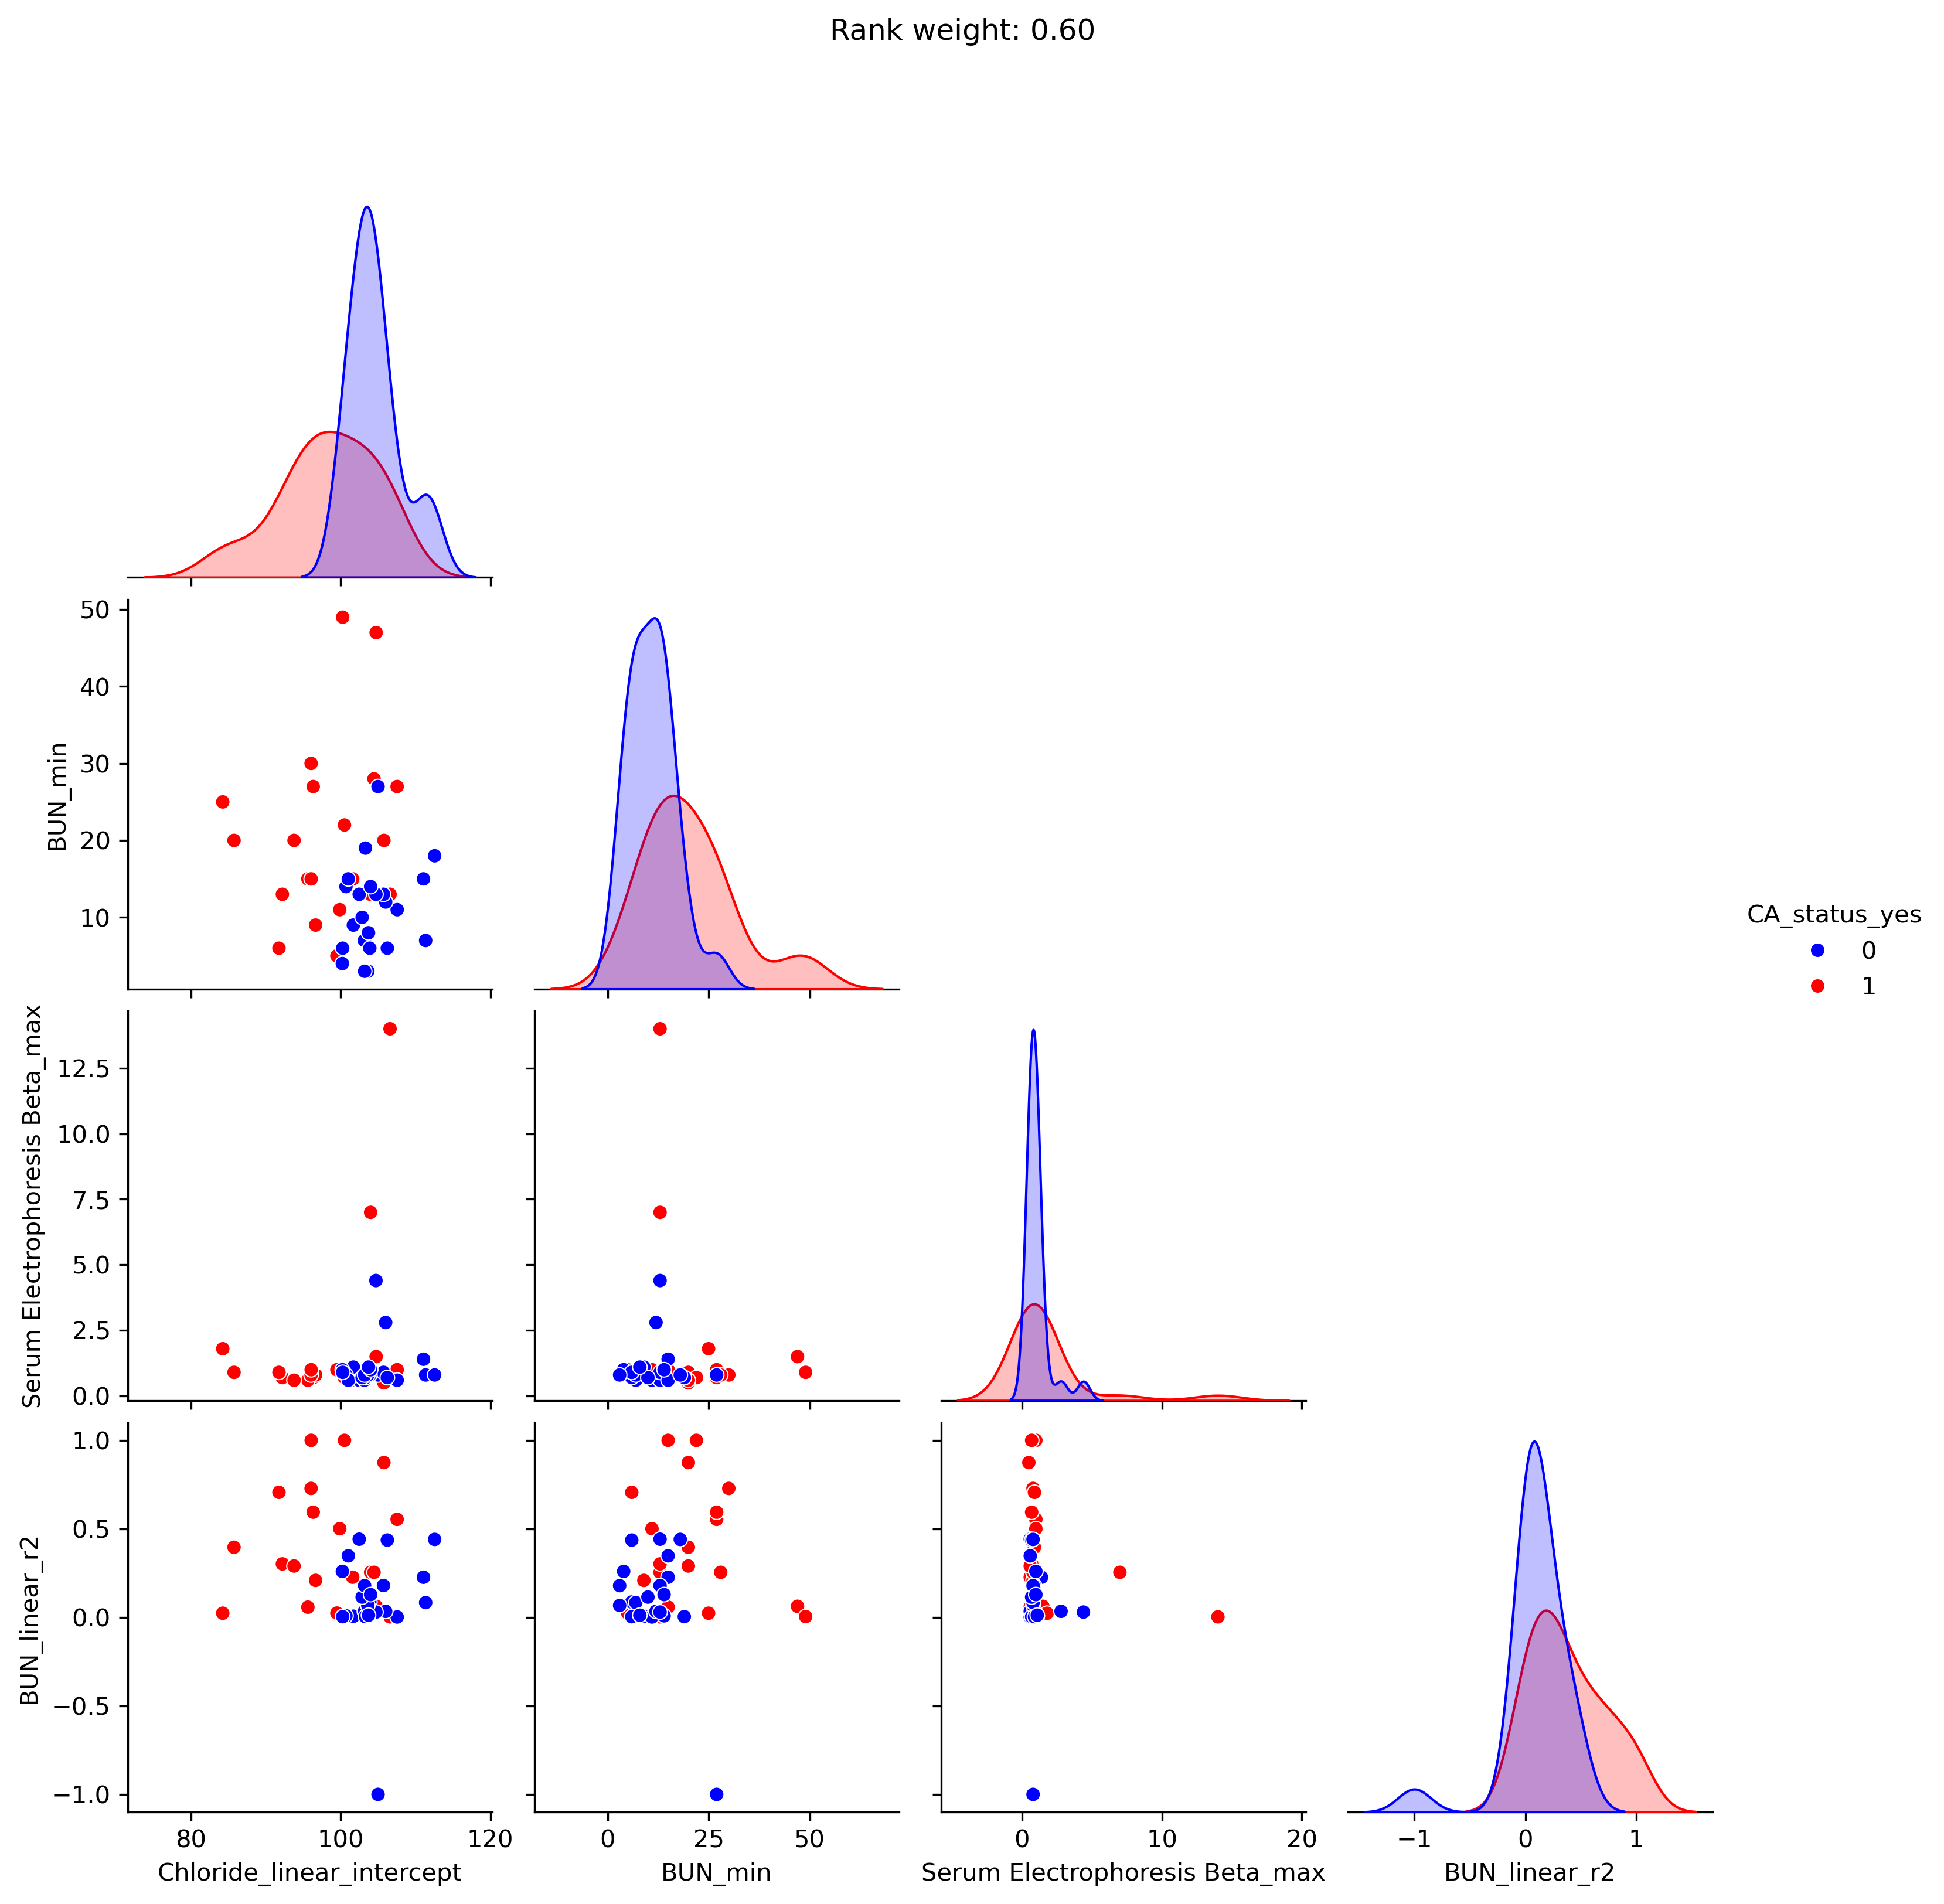

In [139]:
import plotly.express as px
from seaborn import pairplot, clustermap, load_dataset
# fig, ax = plt.subplots()

palette = {np.int64(1) :'red', np.int64(0): 'blue'} #our data is of int64

# selected_model = 0
top_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values
fig = pairplot(dataTable[np.append(top_features, y_column_Classification)],
         hue=y_column_Classification, corner=True, palette=palette)
fig.fig.suptitle(f"Rank weight: {rank_weights[selected_run]:.2f}", y=1.08)

# #saving figure
# figCommon = fileName_common + str(rank_weights[selected_run]).replace(".", "") + "_pairplot"
# figPath = outputFiguresPath(fileName_header=fileName_header, fileName_mid= figCommon, fileName_suff= fileName_suffix, parent_dir= figDirectory, folderName= figFolder)
# fig.savefig(figPath, bbox_inches = 'tight')

## 3D scatter

In [140]:
top3_features = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:3]].values
fig = px.scatter_3d(dataTable, x=top3_features[0], y=top3_features[1], z=top3_features[2],
          color=y_column_Classification)
fig.update_traces(marker_size = 4)
fig.show()

## integrated gradients attribution

In [141]:
IG = svm_set_ranks[selected_run].integrated_gradient(X_all)
IGtable = pd.DataFrame(IG,columns=X.columns[svm_set_ranks[selected_run].features])

features = svm_set_ranks[selected_run].features
IG_X = pd.DataFrame(X_all[:,features],columns = IGtable.columns)
#IG_X = X.iloc[:,features]
N = len(IGtable)

/blue/ferrallm/mcremer/CardiacAmyloidosisMultipleMyeloma/mistic/utility.py:223: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



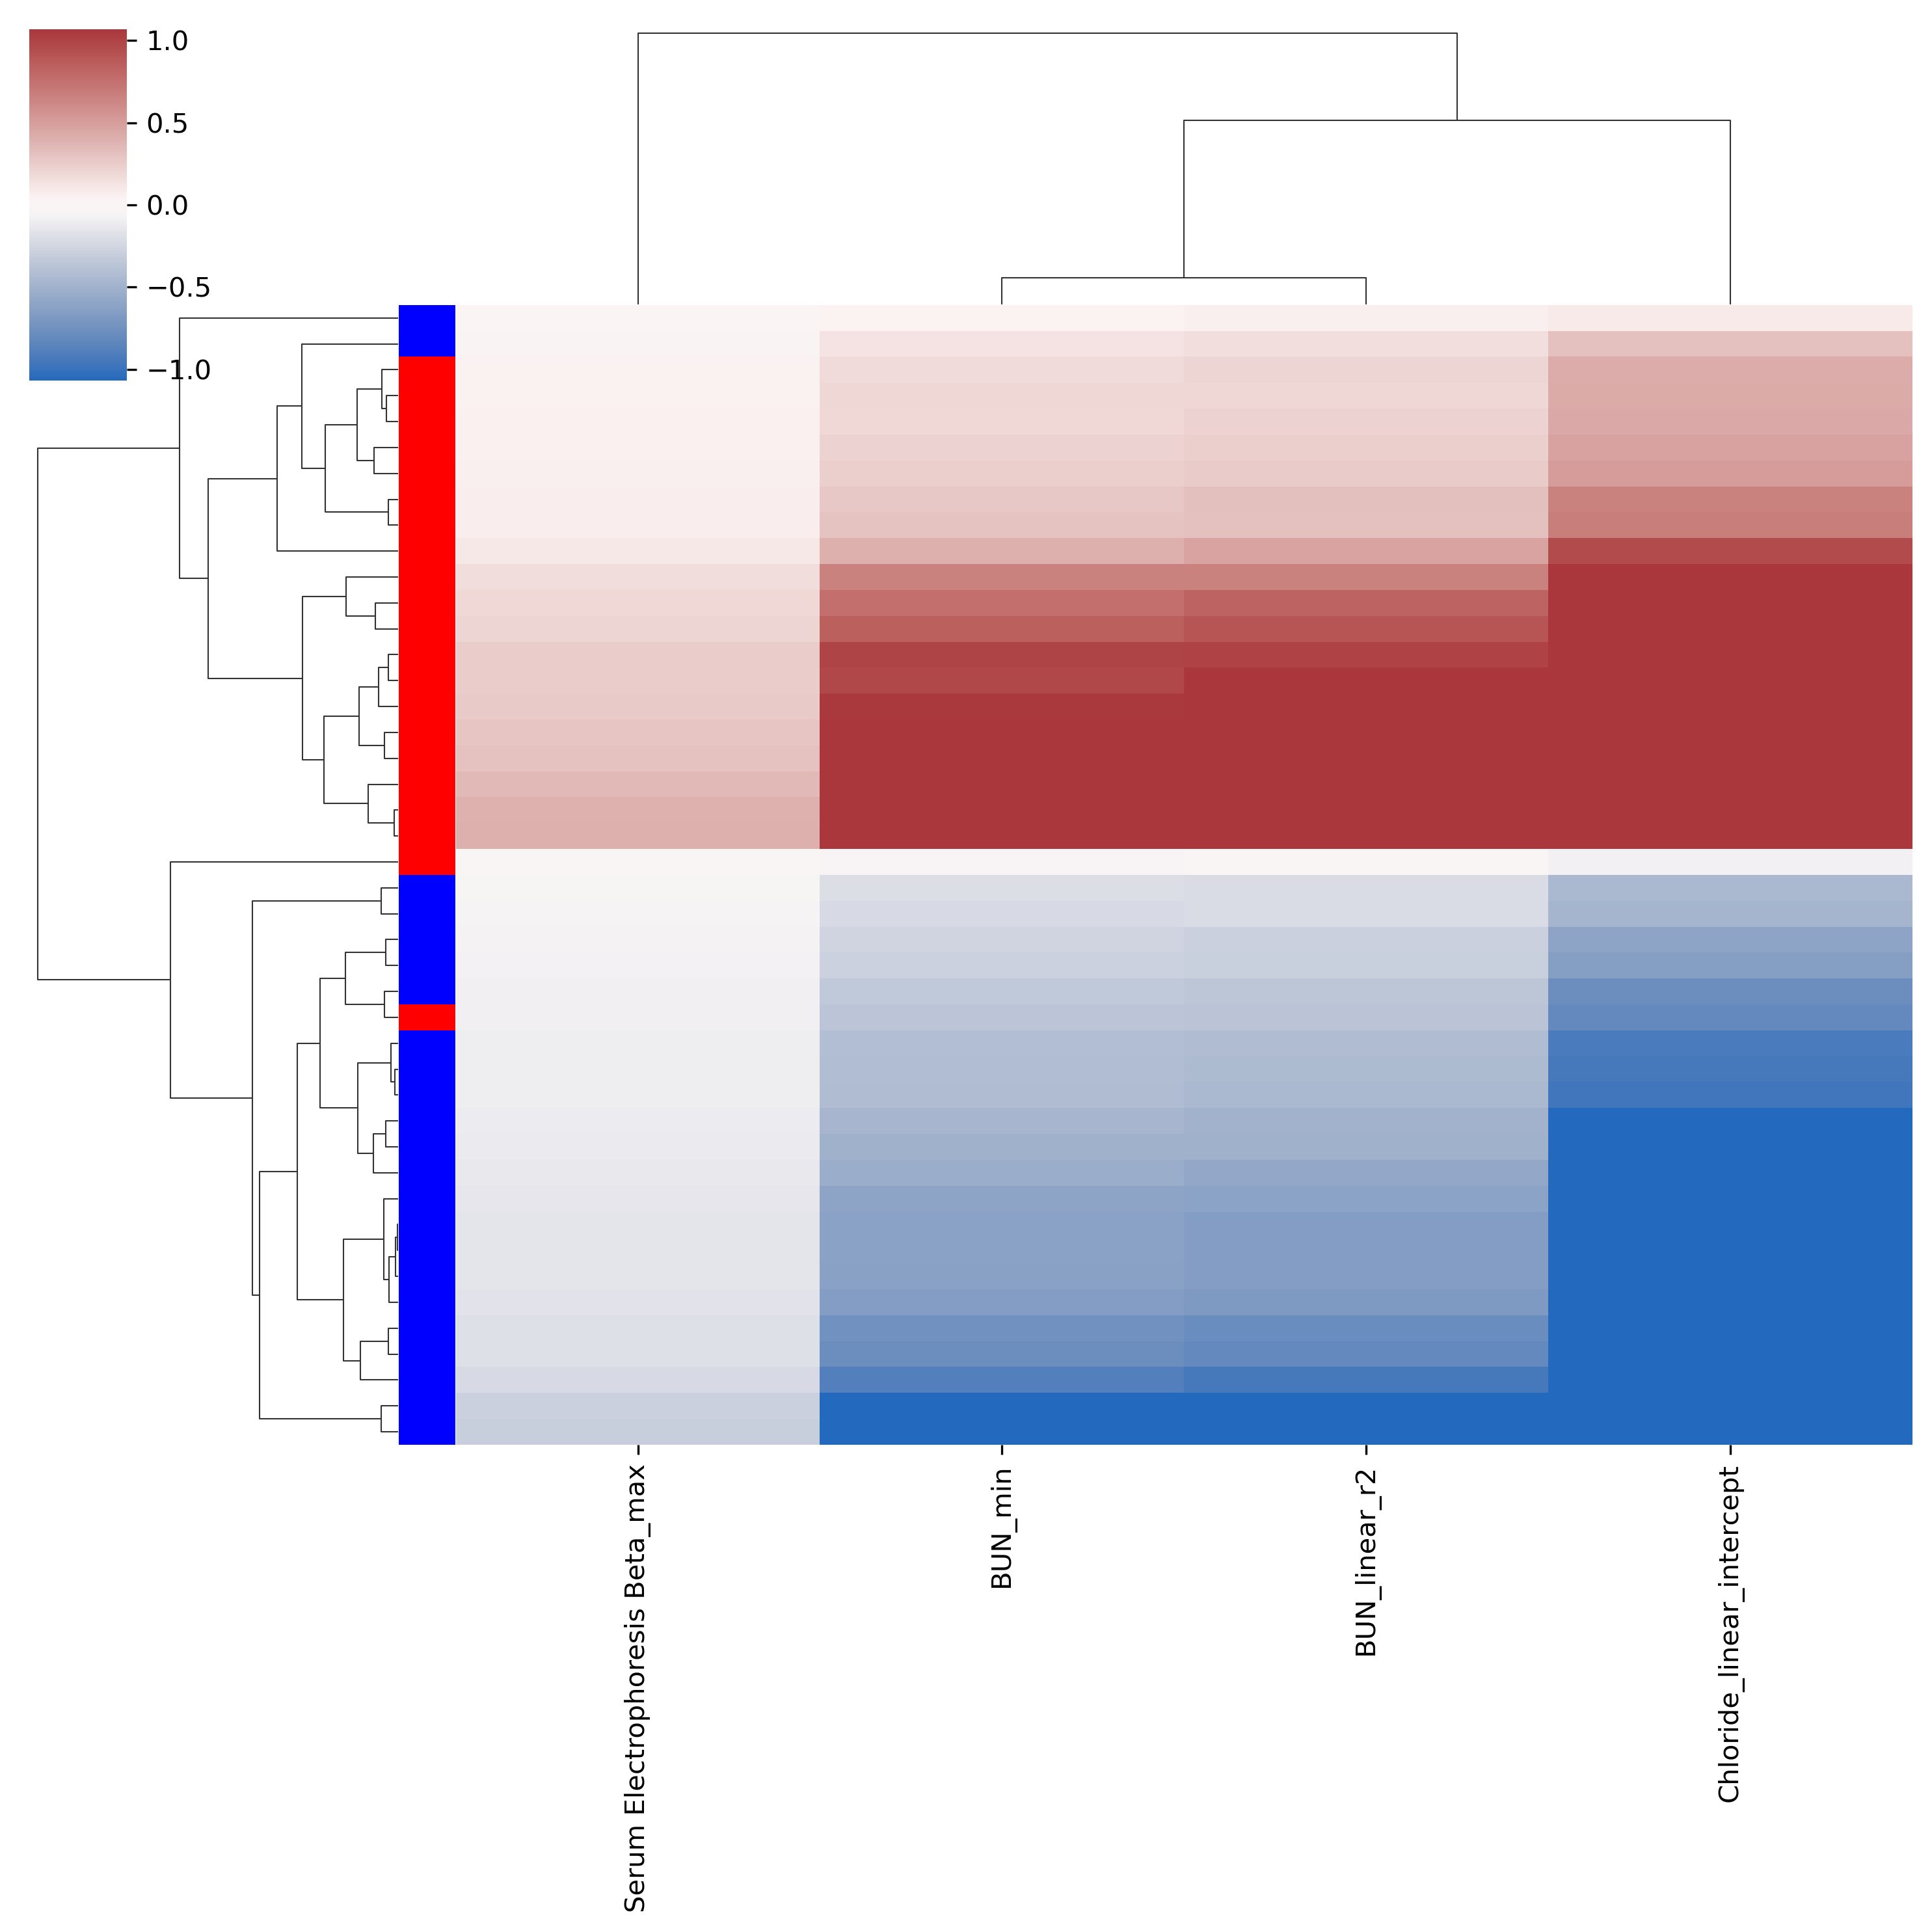

In [142]:
from seaborn import pairplot, clustermap, load_dataset
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list, fcluster

linkMeth = "average"

distMatCol = perDiff(IGtable)
hcCol = linkage(distMatCol, method=linkMeth,optimal_ordering=True)

tr_IGtable = IGtable.transpose()
distMatRow = perDiff(tr_IGtable)
hcRow = linkage(distMatRow, method=linkMeth,optimal_ordering=True)

color_val = max(np.abs((np.mean(IG)-np.std(IG), np.mean(IG)+np.std(IG))))

#fig, ax = plt.subplots()
fig = clustermap(IGtable, 
           yticklabels=False,
           cmap="vlag", vmin=-color_val, vmax=color_val,
           row_linkage=hcRow, col_linkage=hcCol, 
           row_colors=[["red","blue"][int(l==np.int64(0))+0] for l in y_all])

In [143]:
import plotly.graph_objects as go
import plotly.express as px

nbins = 10
scale = 0.1
n_features = len(X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
spacing = 2
min_max_IG = 2.5

fig = go.Figure()
fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=1000,
    height=600,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = "Integrated Gradient",
)
 
fig.update_xaxes(
    zeroline=True,
    zerolinecolor="black",
    range = [-min_max_IG,min_max_IG]
    )
fig.update_yaxes(
    zeroline=True,
    zerolinecolor="black",
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey',
    range = [-spacing, spacing*n_features + spacing]
)
 
feature_rank = np.argsort(np.sum(abs(IG),axis=0))
feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

y_val = 1
bin_ids = list(range(nbins))
for f in feature_order:
    bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
    ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
    x_vals = []
    y_vals = []
    f_vals = []
    for bin in bin_ids:
        x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
        n_pts = len(x_bin_vals)
        if n_pts > 0:
            x_vals = x_vals + x_bin_vals
            y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
            f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
    fig.add_trace(go.Scatter(
        x = x_vals, 
        y = y_vals,
        mode = 'markers',
        marker = dict(size=12,
                      color = f_vals,
                      coloraxis = "coloraxis",
                     ),
        name=IGtable.columns[f],
    ))
    y_val += spacing
 
 
fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text="Feature Value",side = "right"),
                    cmin = -1, cmax = 1)
fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
                 ticktext=IGtable.columns[feature_order])
 
fig.show()

In [144]:
# nbins = 10
# scale = 0.1
# n_features = 12
# spacing = 2
# min_max_IG = 2.5

# fig = go.Figure()
# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=1000,
#     height=2000,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = "Integrated Gradient",
# )
 
# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     range = [-min_max_IG,min_max_IG]
#     )
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor="black",
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey',
#     range = [-spacing, spacing*n_features + spacing]
# )
 
# feature_rank = np.argsort(np.sum(abs(IG),axis=0))
# feature_order = feature_rank[(len(feature_rank)-n_features):len(feature_rank)] 

# y_val = 1
# bin_ids = list(range(nbins))
# for f in feature_order:
#     bins = np.linspace(IGtable.iloc[:,f].min()*1.1,IGtable.iloc[:,f].max()*1.1,nbins+1)
#     ig_bins = pd.cut(IGtable.iloc[:,f], bins=bins, labels=bin_ids)
 
#     x_vals = []
#     y_vals = []
#     f_vals = []
#     for bin in bin_ids:
#         x_bin_vals = list(IGtable.iloc[ig_bins[ig_bins == bin].index,f].values)
#         n_pts = len(x_bin_vals)
#         if n_pts > 0:
#             x_vals = x_vals + x_bin_vals
#             y_vals = y_vals + list(y_val + scale*(np.array(list(range(n_pts)))-(n_pts-1)/2))
#             f_vals = f_vals + list(IG_X.iloc[ig_bins[ig_bins == bin].index,f].values)
#     fig.add_trace(go.Scatter(
#         x = x_vals, 
#         y = y_vals,
#         mode = 'markers',
#         marker = dict(size=12,
#                       color = f_vals,
#                       coloraxis = "coloraxis",
#                      ),
#         name=IGtable.columns[f],
#     ))
#     y_val += spacing
 
 
# fig.update_layout(showlegend=False, coloraxis_showscale=True,font=dict(size=20))
# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text="Feature Value",side = "right"),
#                     cmin = -1, cmax = 1)
# fig.update_yaxes(tickvals=[1]+[1 + spacing*i for i in range(1,n_features)], 
#                  ticktext=IGtable.columns[feature_order])
 
# fig.show()

In [145]:
feat_1 = IGtable.columns[feature_order[0]]
feat_2 = IGtable.columns[feature_order[1]]

fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
fig.update_traces(marker=dict(size=12))

fig.update_layout(
    plot_bgcolor='white',
    autosize=False,
    width=800,
    height=800,
    coloraxis = {'colorscale':'Bluered'},
    xaxis_title = feat_1,
    yaxis_title = "Integrated Gradient for " + feat_1,
    font=dict(size=20)
)

fig.update_xaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    
fig.update_yaxes(
    zeroline=True,
    zerolinecolor='lightgrey',
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
)

fig.update_coloraxes(colorbar_showticklabels=False,
                    colorbar_title=dict(text=feat_2,side = "right"),
                    cmin = -1, cmax = 1)

fig.show()

In [146]:
# feat_1 = IGtable.columns[feature_order[5]]
# feat_2 = IGtable.columns[feature_order[6]]

# fig = px.scatter(x = IG_X[feat_1], y = IGtable[feat_1], color = IG_X[feat_2])
# fig.update_traces(marker=dict(size=12))

# fig.update_layout(
#     plot_bgcolor='white',
#     autosize=False,
#     width=800,
#     height=800,
#     coloraxis = {'colorscale':'Bluered'},
#     xaxis_title = feat_1,
#     yaxis_title = "Integrated Gradient for " + feat_1,
#     font=dict(size=20)
# )

# fig.update_xaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
#     )
    
# fig.update_yaxes(
#     zeroline=True,
#     zerolinecolor='lightgrey',
#     mirror=True,
#     ticks='outside',
#     showline=True,
#     linecolor='black',
#     gridcolor='lightgrey'
# )

# fig.update_coloraxes(colorbar_showticklabels=False,
#                     colorbar_title=dict(text=feat_2,side = "right"),
#                     cmin = -1, cmax = 1)

# fig.show()

# sensitivity and specificity 

In [147]:
decision_values = svm_set_ranks[selected_run].decision_function(X_test)
y_pred = svm_set_ranks[selected_run].predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
precision = tp/(tp+fp)
recall = tp/(tp+fn)
specificity = tn/(tn + fp)
f1 = 2*precision*recall/(precision+recall)
auc = roc_auc_score(y_test, decision_values)

print("True Negative: ", tn)
print("false positive: ", fp)
print("false negative: ", fn)
print("true positive: ", tp)
print("true positive rate or recall/sensitivity: ", recall)
print("positive predictive value or precision: ", precision)
print("specificity or true negatie rate: ", specificity)
print("auc: ", auc)
print("f1 score: ", f1)

True Negative:  4
false positive:  1
false negative:  2
true positive:  3
true positive rate or recall/sensitivity:  0.6
positive predictive value or precision:  0.75
specificity or true negatie rate:  0.8
auc:  0.88
f1 score:  0.6666666666666665


# testing alt models on best feature list

In [148]:
X_all_trim = X_all[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_train_trim = X_train[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
X_test_trim = X_test[:,svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]]
#making the dataset only include the features from the best performing model in SVM

In [149]:
cv_set_trim = cvSet(X = X_train_trim, y = y_train.values)
cv_set_trim.classification(num_sets = numb_sets)

F1:  0.7272727272727273
ROC:  0.7000000000000001


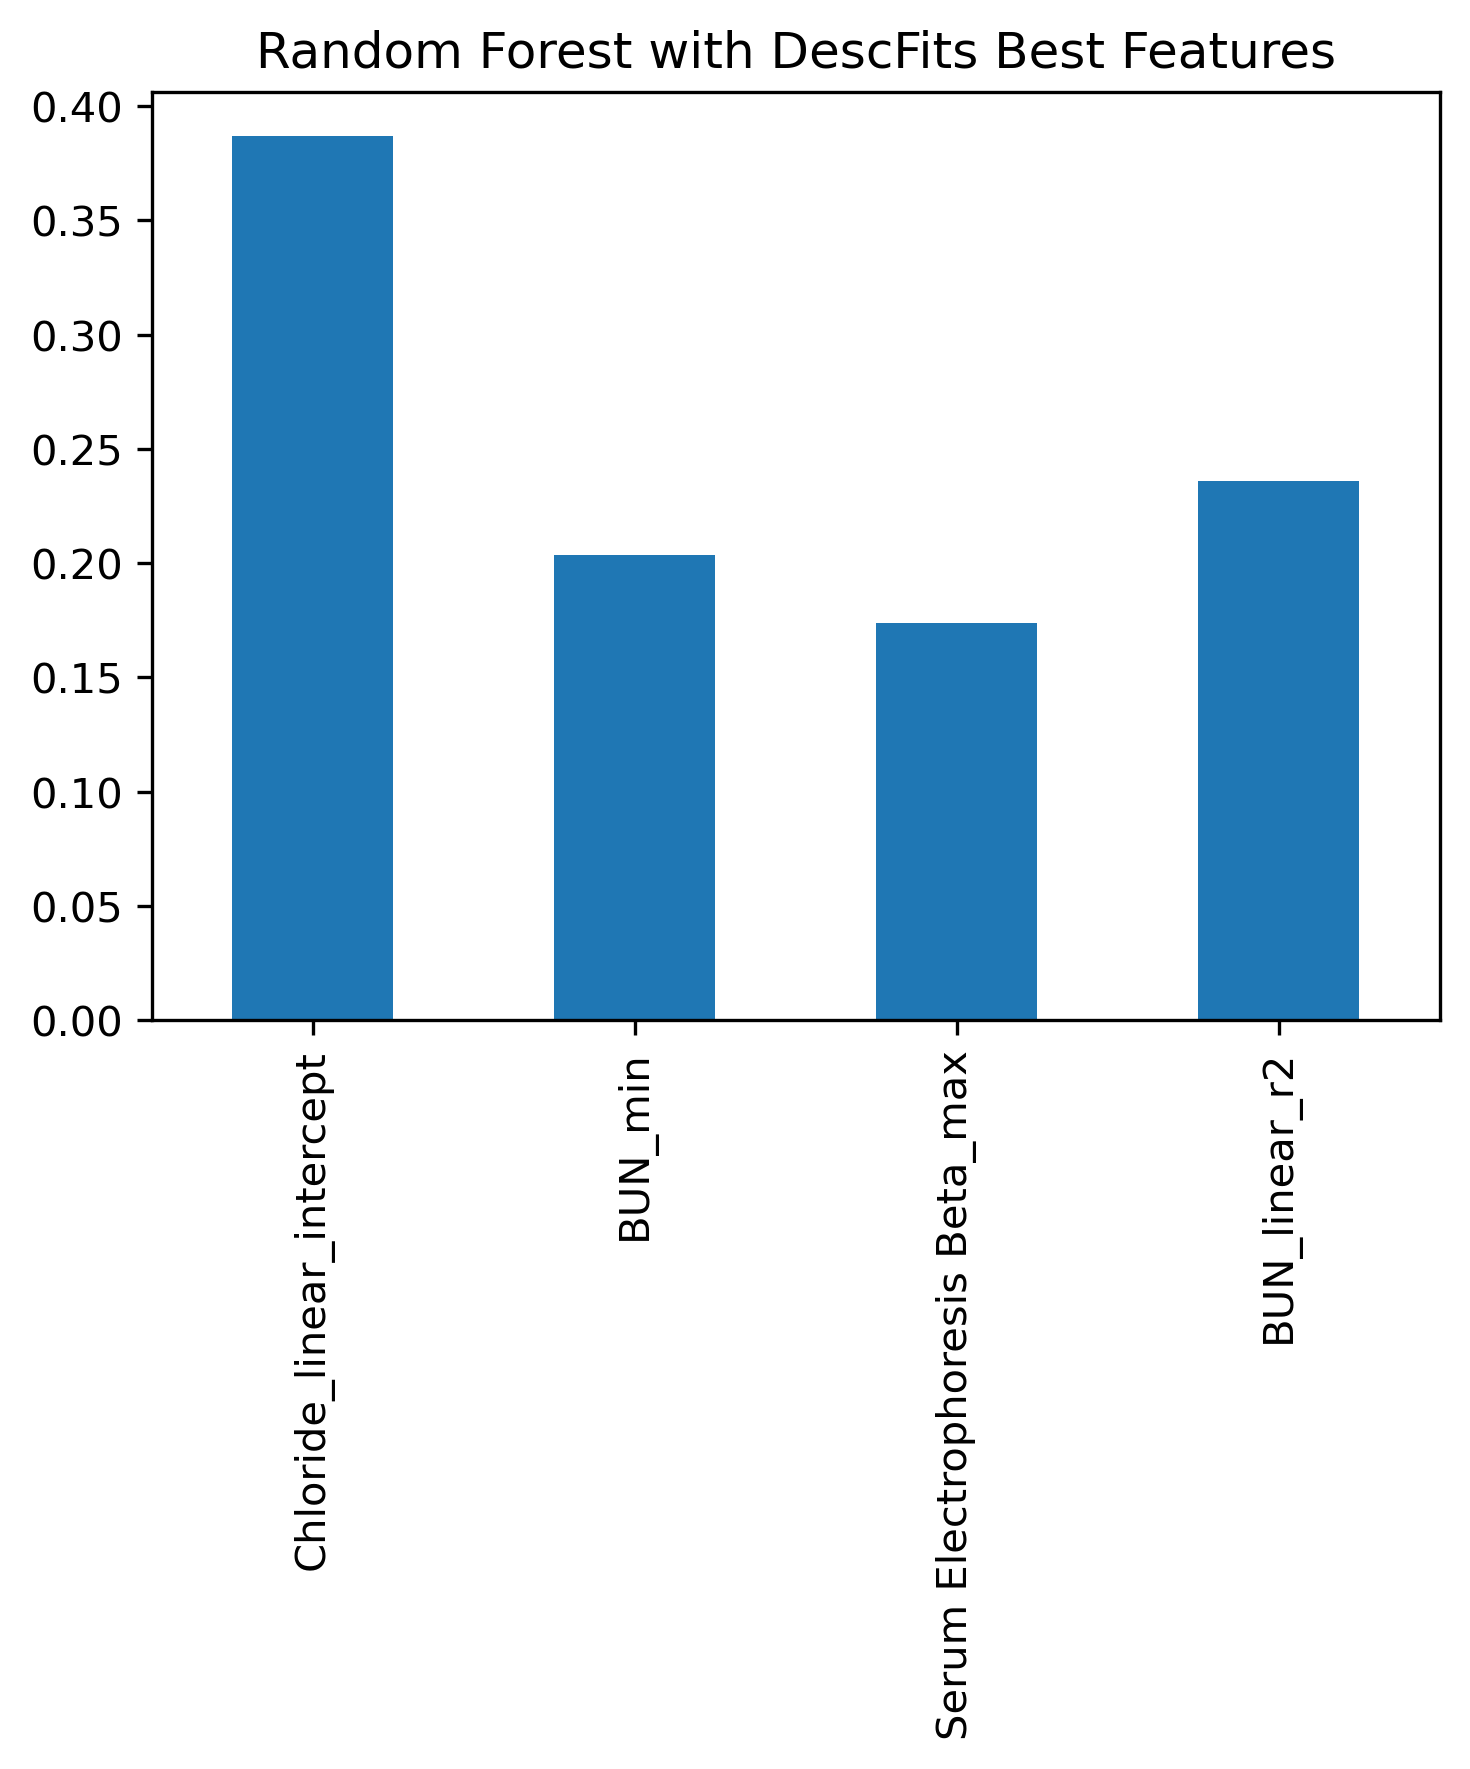

In [150]:
rnd_clf = RandomForestClassifier(random_state=randomSeed)
rnd_clf.fit(X_train_trim, y_train)
y_pred = rnd_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances = rnd_clf.feature_importances_
forest_importances = pd.Series(importances, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
forest_importances.plot.bar(ax=ax)
ax.set_title("Random Forest with DescFits Best Features")
fig.tight_layout()

F1:  0.7272727272727273
ROC:  0.7000000000000001


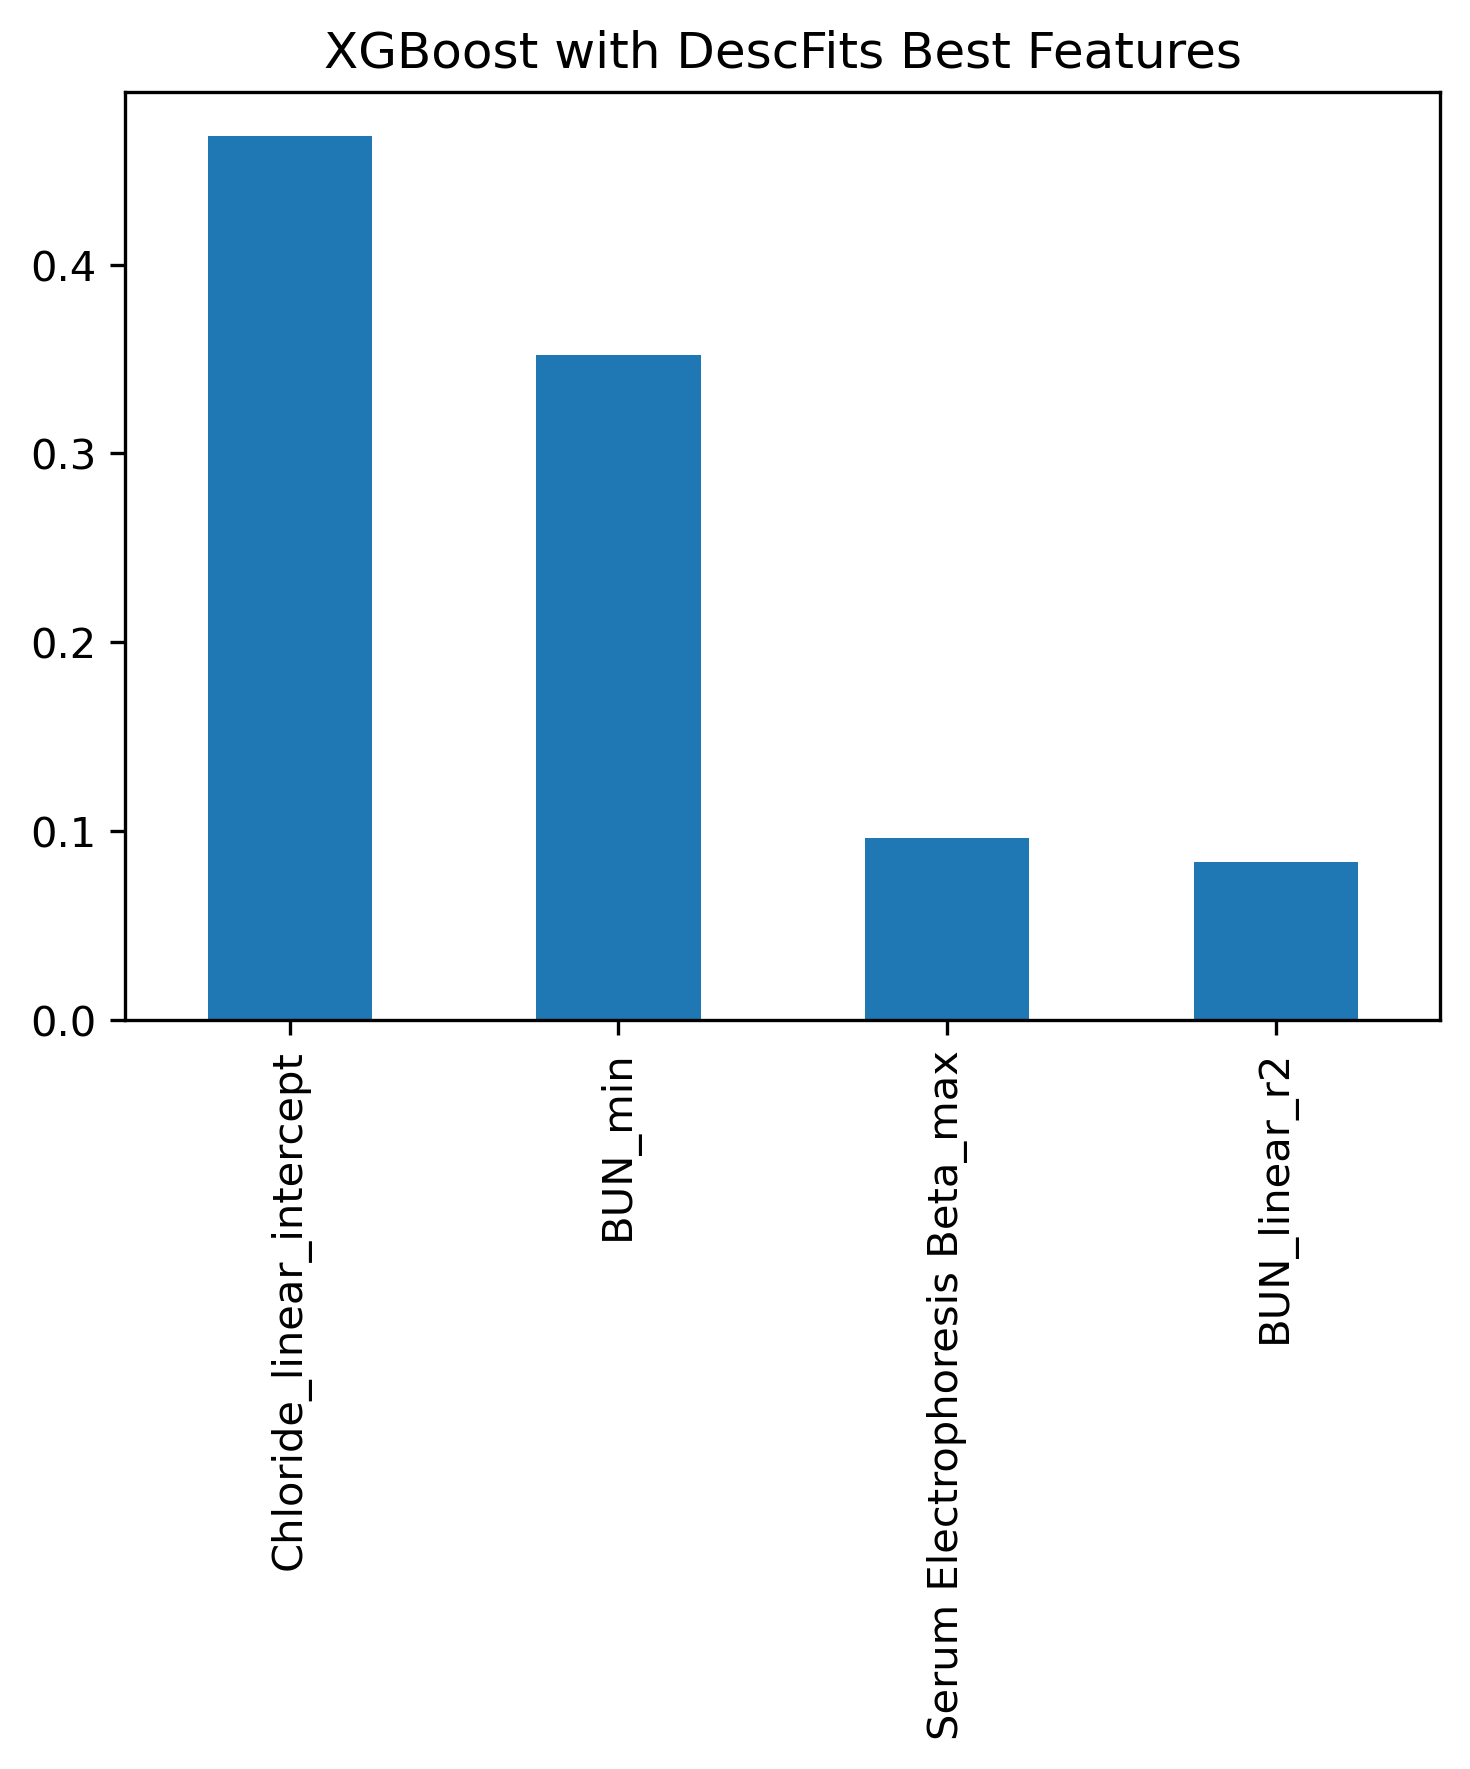

In [151]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train_trim, y_train)
y_pred = xgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = 'binary'))
print("ROC: ", roc_auc_score(y_test, y_pred))

importances_xgb = xgb_clf.feature_importances_
xgb_importances = pd.Series(importances_xgb, index= X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)
fig, ax = plt.subplots(figsize = (5,6))
xgb_importances.plot.bar(ax=ax)
ax.set_title("XGBoost with DescFits Best Features")
fig.tight_layout()

In [152]:
paramsLGBM = {
    'objective': 'binary',
    'boosting_type':'gbdt',
    # 'num_leaves' : 45, 
    'learning_rate' : 0.05,
    'feature_fraction' : 0.90,
    'min_data_in_leaf': 1
}

lgb_clf = lgb.LGBMClassifier(**paramsLGBM)
lgb_clf.fit(X_train_trim, y_train)
y_pred = lgb_clf.predict(X_test_trim)

print("F1: ", f1_score(y_test, y_pred, average = "binary"))
print("ROC: ", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 16, number of negative: 18
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 45
[LightGBM] [Info] Number of data points in the train set: 34, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.470588 -> initscore=-0.117783
[LightGBM] [Info] Start training from score -0.117783
[LightGBM] [Warning] No furthe

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


/blue/ferrallm/mcremer/.conda/envs/mcremerConda_2024-07-15_v1/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



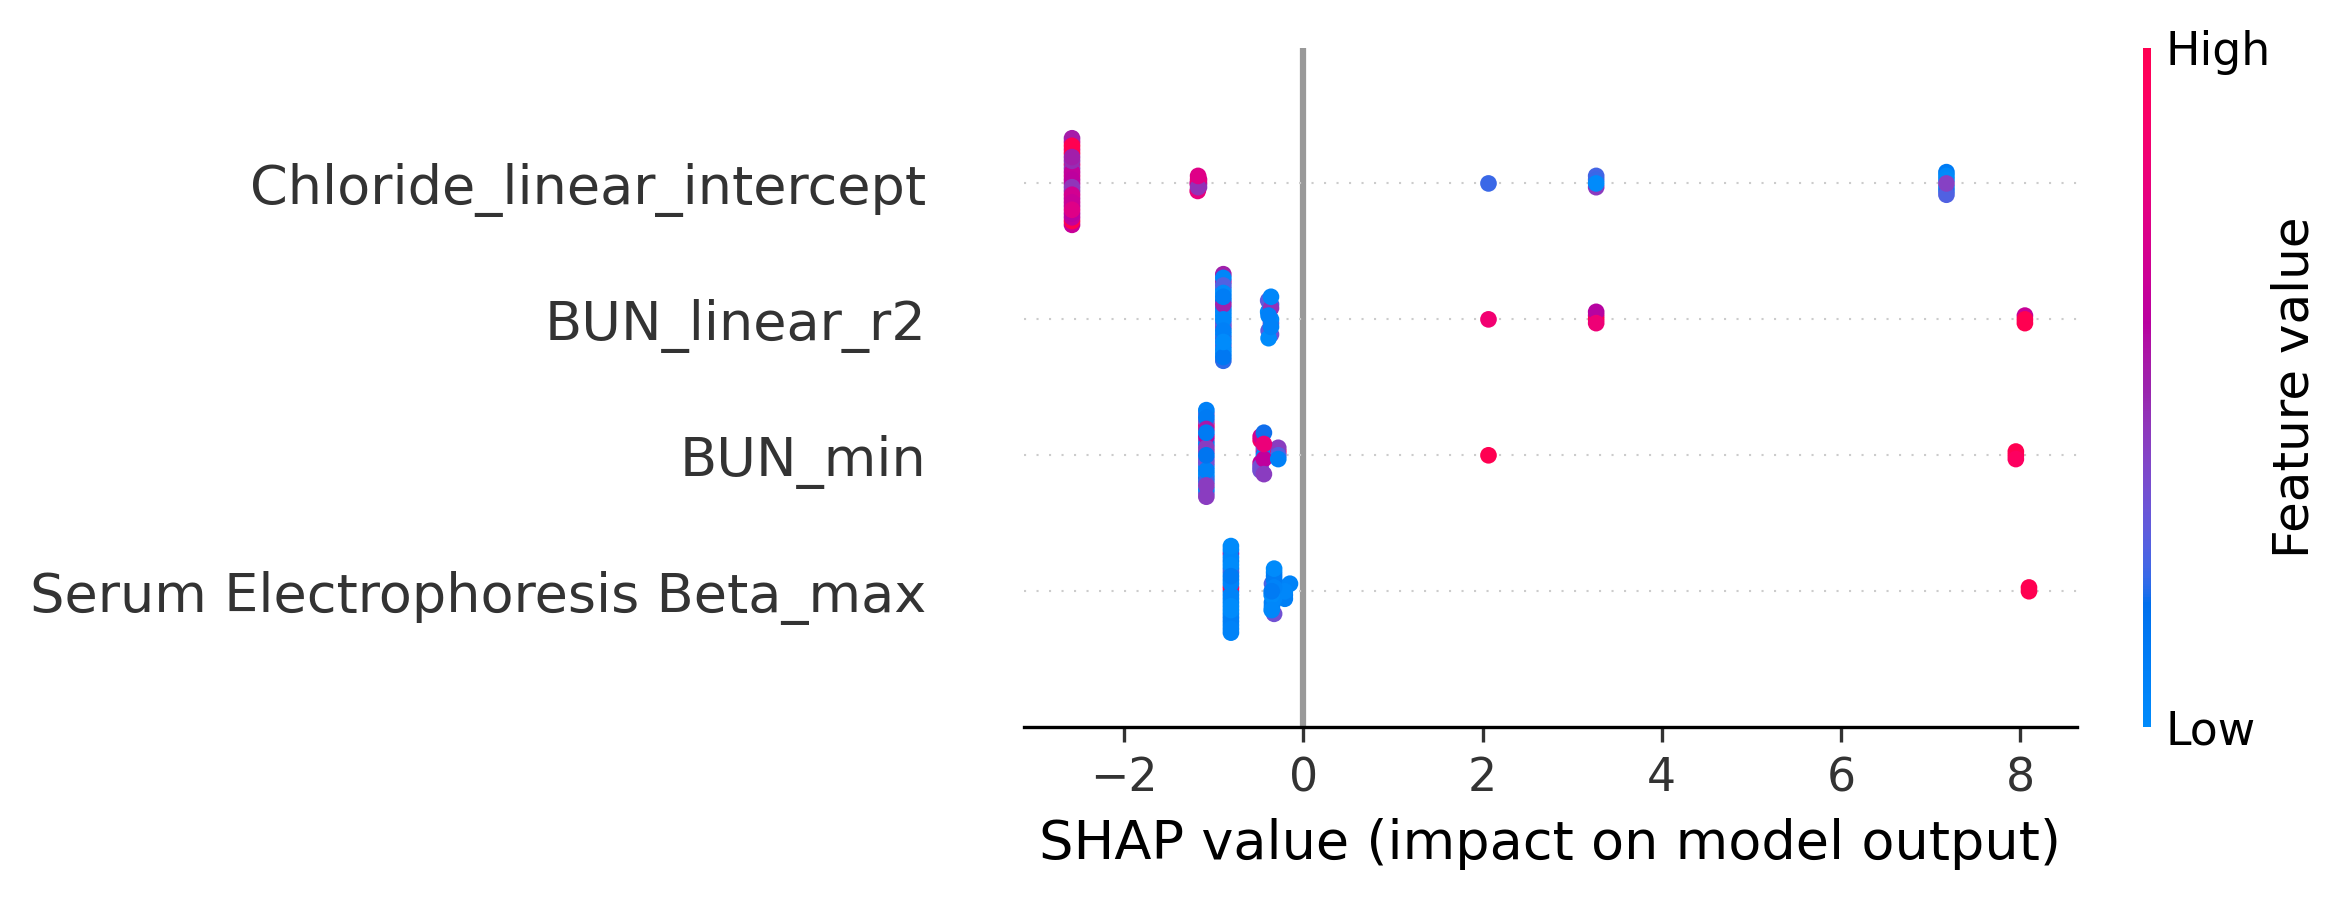

In [153]:
#borrowed from online source
#shap explainer
explainer = shap.TreeExplainer(lgb_clf)

#binary predictions
y_proba = lgb_clf.predict_proba(X_all_trim)[:,1]

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_all_trim)

shap.summary_plot(shap_values, X_all_trim, feature_names = X.columns[svm_set_ranks[selected_run].sorted_features.astype(int)[:svm_set_ranks[selected_run].performance_["num_features"]]].values)

# Show the plot
plt.show()

# exporting selected features to dataframe

In [154]:
selected_features = list(X.columns[svm_set_ranks[selected_run].features]) #getting list of selected features
dataTablePositive = dataTable[dataTable[y_column_Classification] == 1] #filtering for positive patients
dataTablePositive.index = dataTablePositive['DeID'] #setting index to patient id
dataTableNegative = dataTable[dataTable[y_column_Classification] == 0] #filtering for negative patients
dataTableNegative.index = dataTableNegative['DeID'] #setting index to patient id
df_selectedfeatures_allpts = dataTable[selected_features]
df_selectedfeatures_allpts.index = dataTable['DeID'] #adding the patient identifiers back to the dataframe


#saving this output to a sheet
outputToExcel(df_data = df_selectedfeatures_allpts[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = dataTablePositive[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "positive")
outputToExcel(df_data = dataTableNegative[selected_features], fileName_header= "SelectedFeats_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "negative")


# correlation and heat maps for the best performing features of the SVM model

In [155]:
import seaborn as sns

In [156]:
dataTable

DeID  CA_status_yes  sex_female  dx_mgus  dx_mm  age  survival(mo)  \
DeID                                                                       
B-02  B-02              1           0        1      0   48      9.466667   
C-03  C-03              1           1        0      1   59     17.000000   
E-01  E-01              1           0        1      0   50     71.300000   
E-02  E-02              1           0        1      0   64     20.466667   
F-03  F-03              1           0        0      1   61     52.000000   
G-02  G-02              1           1        0      1   36     30.000000   
I-01  I-01              1           1        0      1   55     33.000000   
I-03  I-03              1           0        1      0   67     10.033333   
J-02  J-02              1           1        0      1   68     26.000000   
K-02  K-02              1           1        0      1   68     27.000000   
M-02  M-02              1           0        1      0   70     24.800000   
N-03  N-03              1           0        0      1   69      8.000000   
O-03  O-03              1           1        0      1   71      4.233333   
Q-02  Q-02              1           0        1      0   69     41.100000   
Q-03  Q-03              1           1        0      1   41      3.466667   
T-01  T-01              1           0        0      0   71     14.433333   
V-02  V-02              1           0        0      1   79     50.000000   
W-01  W-01              1           0        0      1   57     42.000000   
X-01  X-01              1           0        1      0   80      5.300000   
X-02  X-02              1           0        1      0   63     38.233333   
Y-02  Y-02              1           1        1      0   57     12.766667   
A-02  A-02              0           1        1      0   74      7.266667   
B-03  B-03              0           0        0      1   43     18.000000   
C-01  C-01              0           1        0      0   56     27.000000   
C-02  C-02              0           0        0      1   59     33.000000   
E-03  E-03              0           0        1      0   62     13.866667   
F-01  F-01              0           0        0      1   55    147.000000   
G-03  G-03              0           1        1      0   69     11.533333   
H-01  H-01              0           0        1      0   56     47.066667   
H-02  H-02              0           0        0      1   65     26.000000   
M-01  M-01              0           0        0      1   47     83.000000   
N-01  N-01              0           0        0      0   79     15.000000   
N-02  N-02              0           0        0      1   76     10.000000   
P-01  P-01              0           0        0      1   77     53.000000   
P-02  P-02              0           1        0      1   64     26.000000   
Q-01  Q-01              0           1        1      0   57     48.800000   
R-01  R-01              0           0        0      1   68     21.000000   
R-03  R-03              0           1        1      0   62     12.966667   
S-02  S-02              0           1        0      1   69     20.000000   
T-02  T-02              0           0        0      1   60     19.000000   
V-01  V-01              0           1        0      1   66     43.000000   
W-02  W-02              0           0        1      0   72     13.500000   
Y-01  Y-01              0           0        0      1   59     40.000000   
Z-01  Z-01              0           1        0      0   72      2.000000   

      ChemoTx  HematologicTx  RadiationTx  ...  total CO2_exp_mse  \
DeID                                       ...                      
B-02        0              0            0  ...       2.011979e-03   
C-03        2              0            0  ...       1.501745e-02   
E-01        0              0            0  ...       2.411961e-02   
E-02        0              0            0  ...       1.051799e-04   
F-03        4              1            0  ...       4.245450e-03   
G-02        0             

In [157]:
# create correlation matrix for all the input features
feature_correlation = dataTable.drop(columns= 'DeID').corr(method='spearman')
selected_features = list(X.columns[svm_set_ranks[selected_run].features])

#for CA positive
feature_correlation_CApositive = dataTable[dataTable[y_column_Classification] == 1].drop(columns = "DeID").corr(method='spearman')

#for CA negative
feature_correlation_CAnegative = dataTable[dataTable[y_column_Classification] == 0].drop(columns = "DeID").corr(method='spearman')

In [158]:
outputToExcel(df_data = feature_correlation, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "all")
outputToExcel(df_data = feature_correlation_CApositive, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCApos")
outputToExcel(df_data = feature_correlation_CAnegative, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix,
                    parent_dir= saving_dirrectory, folderName=makingFolder, sheetName= "allCAneg")

In [159]:
colormap = "RdBu"

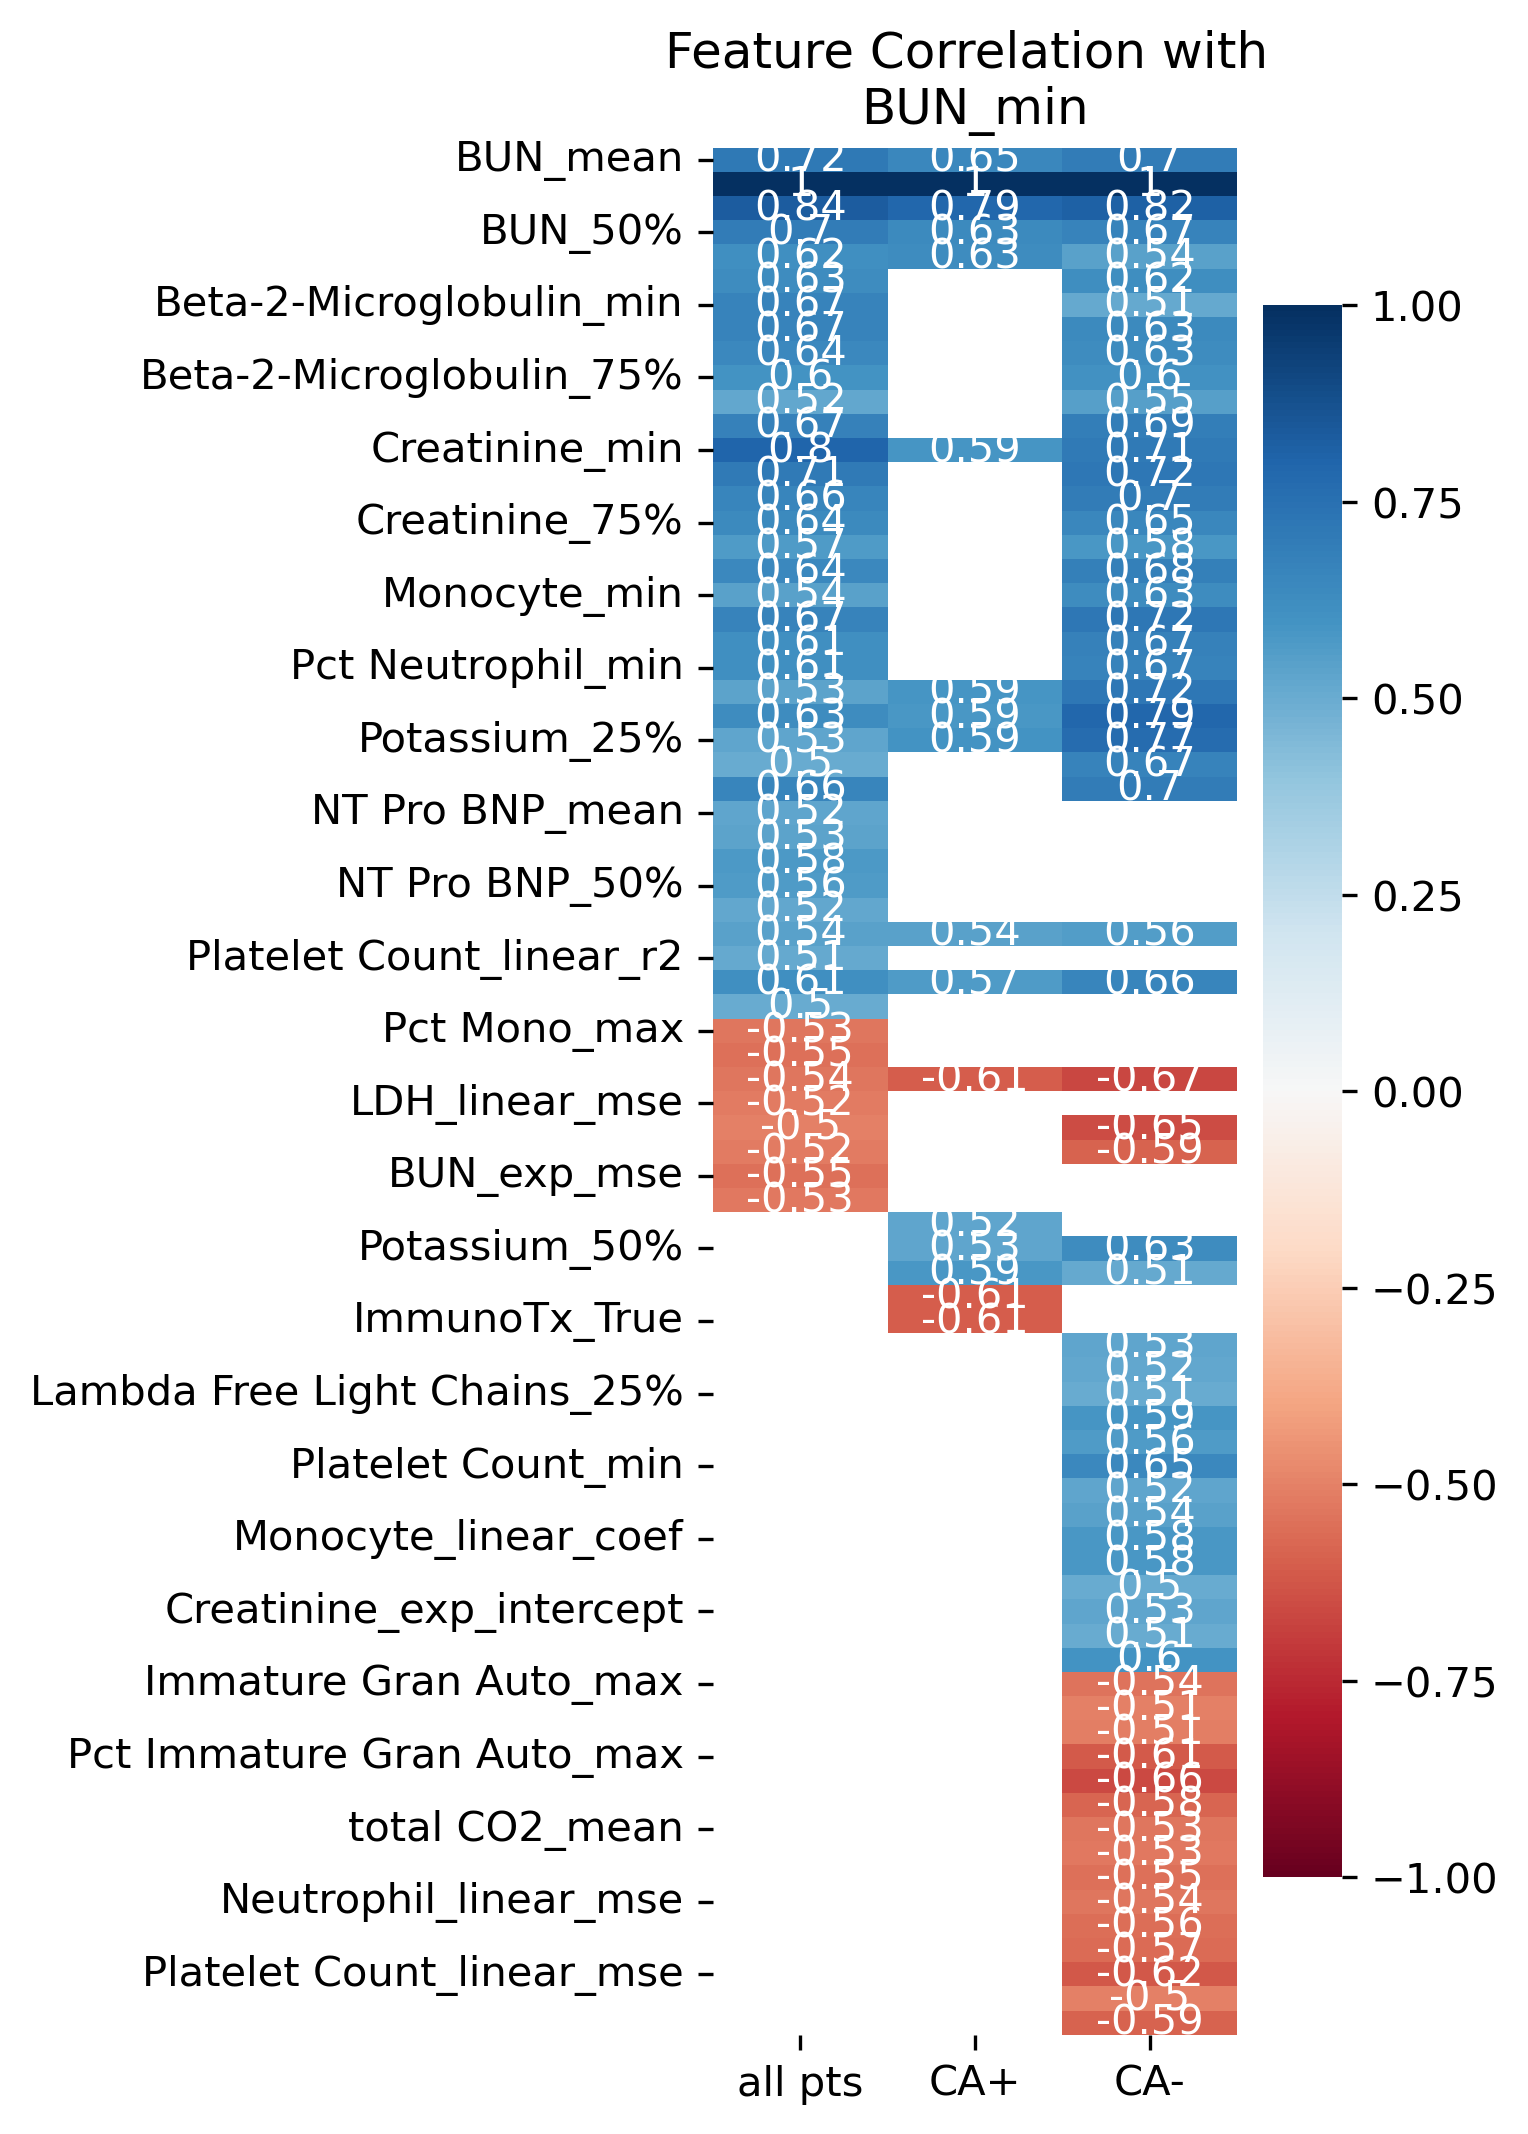

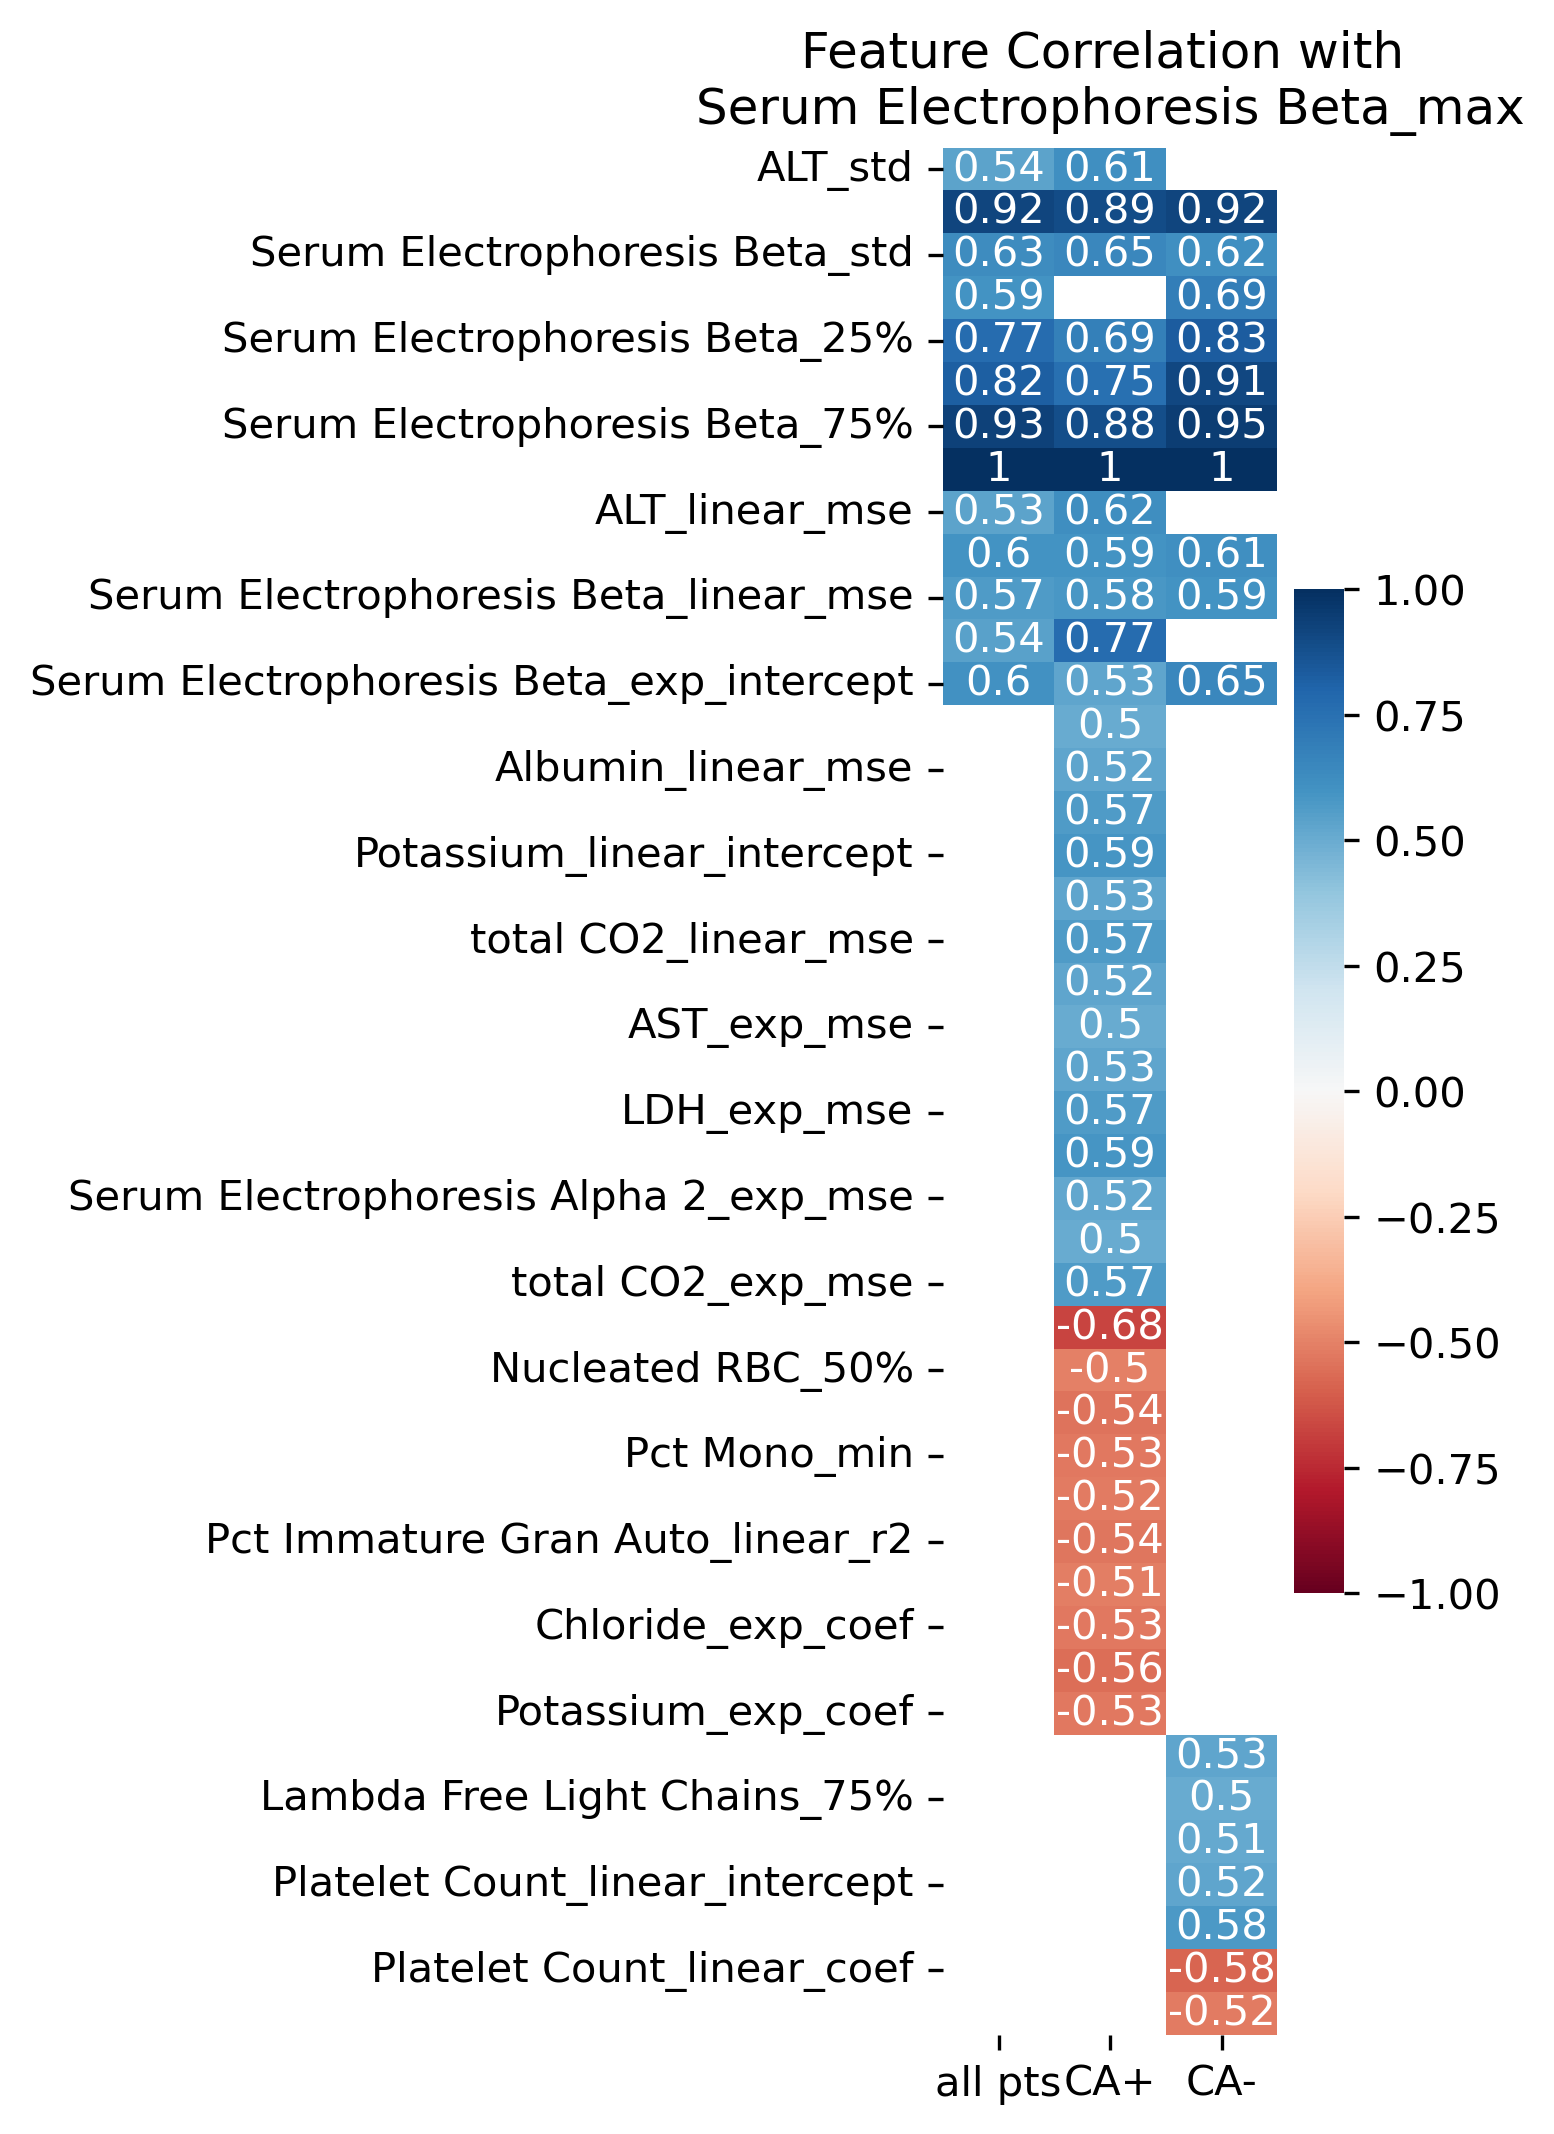

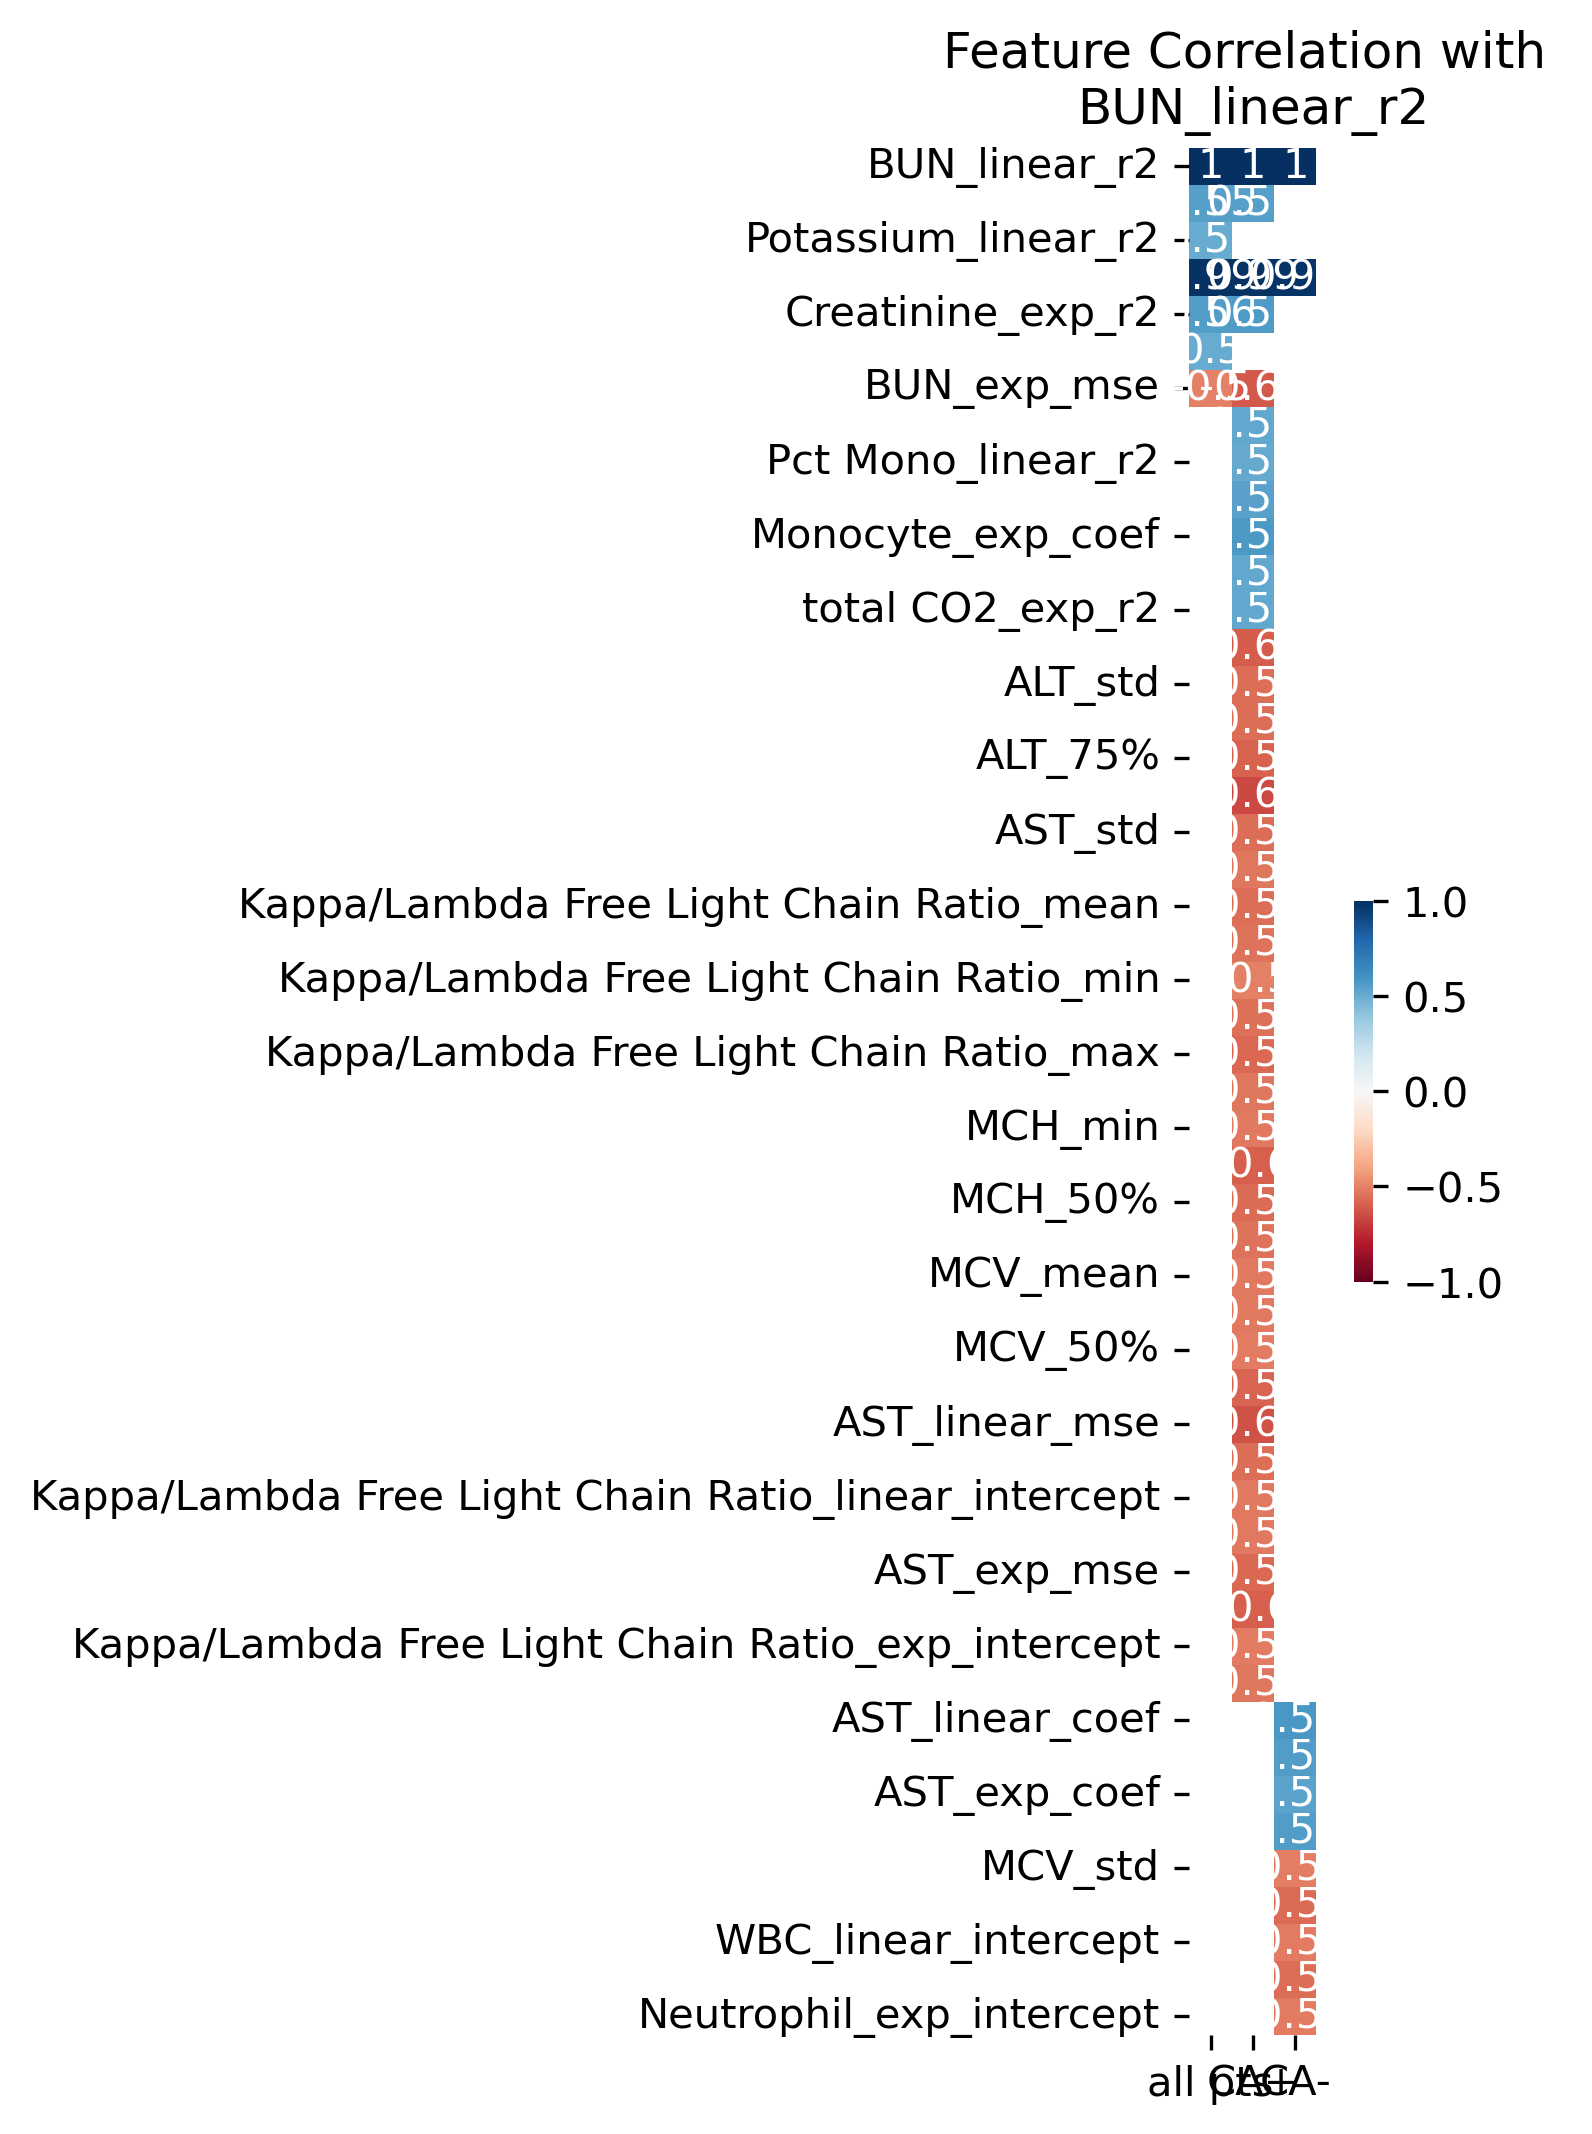

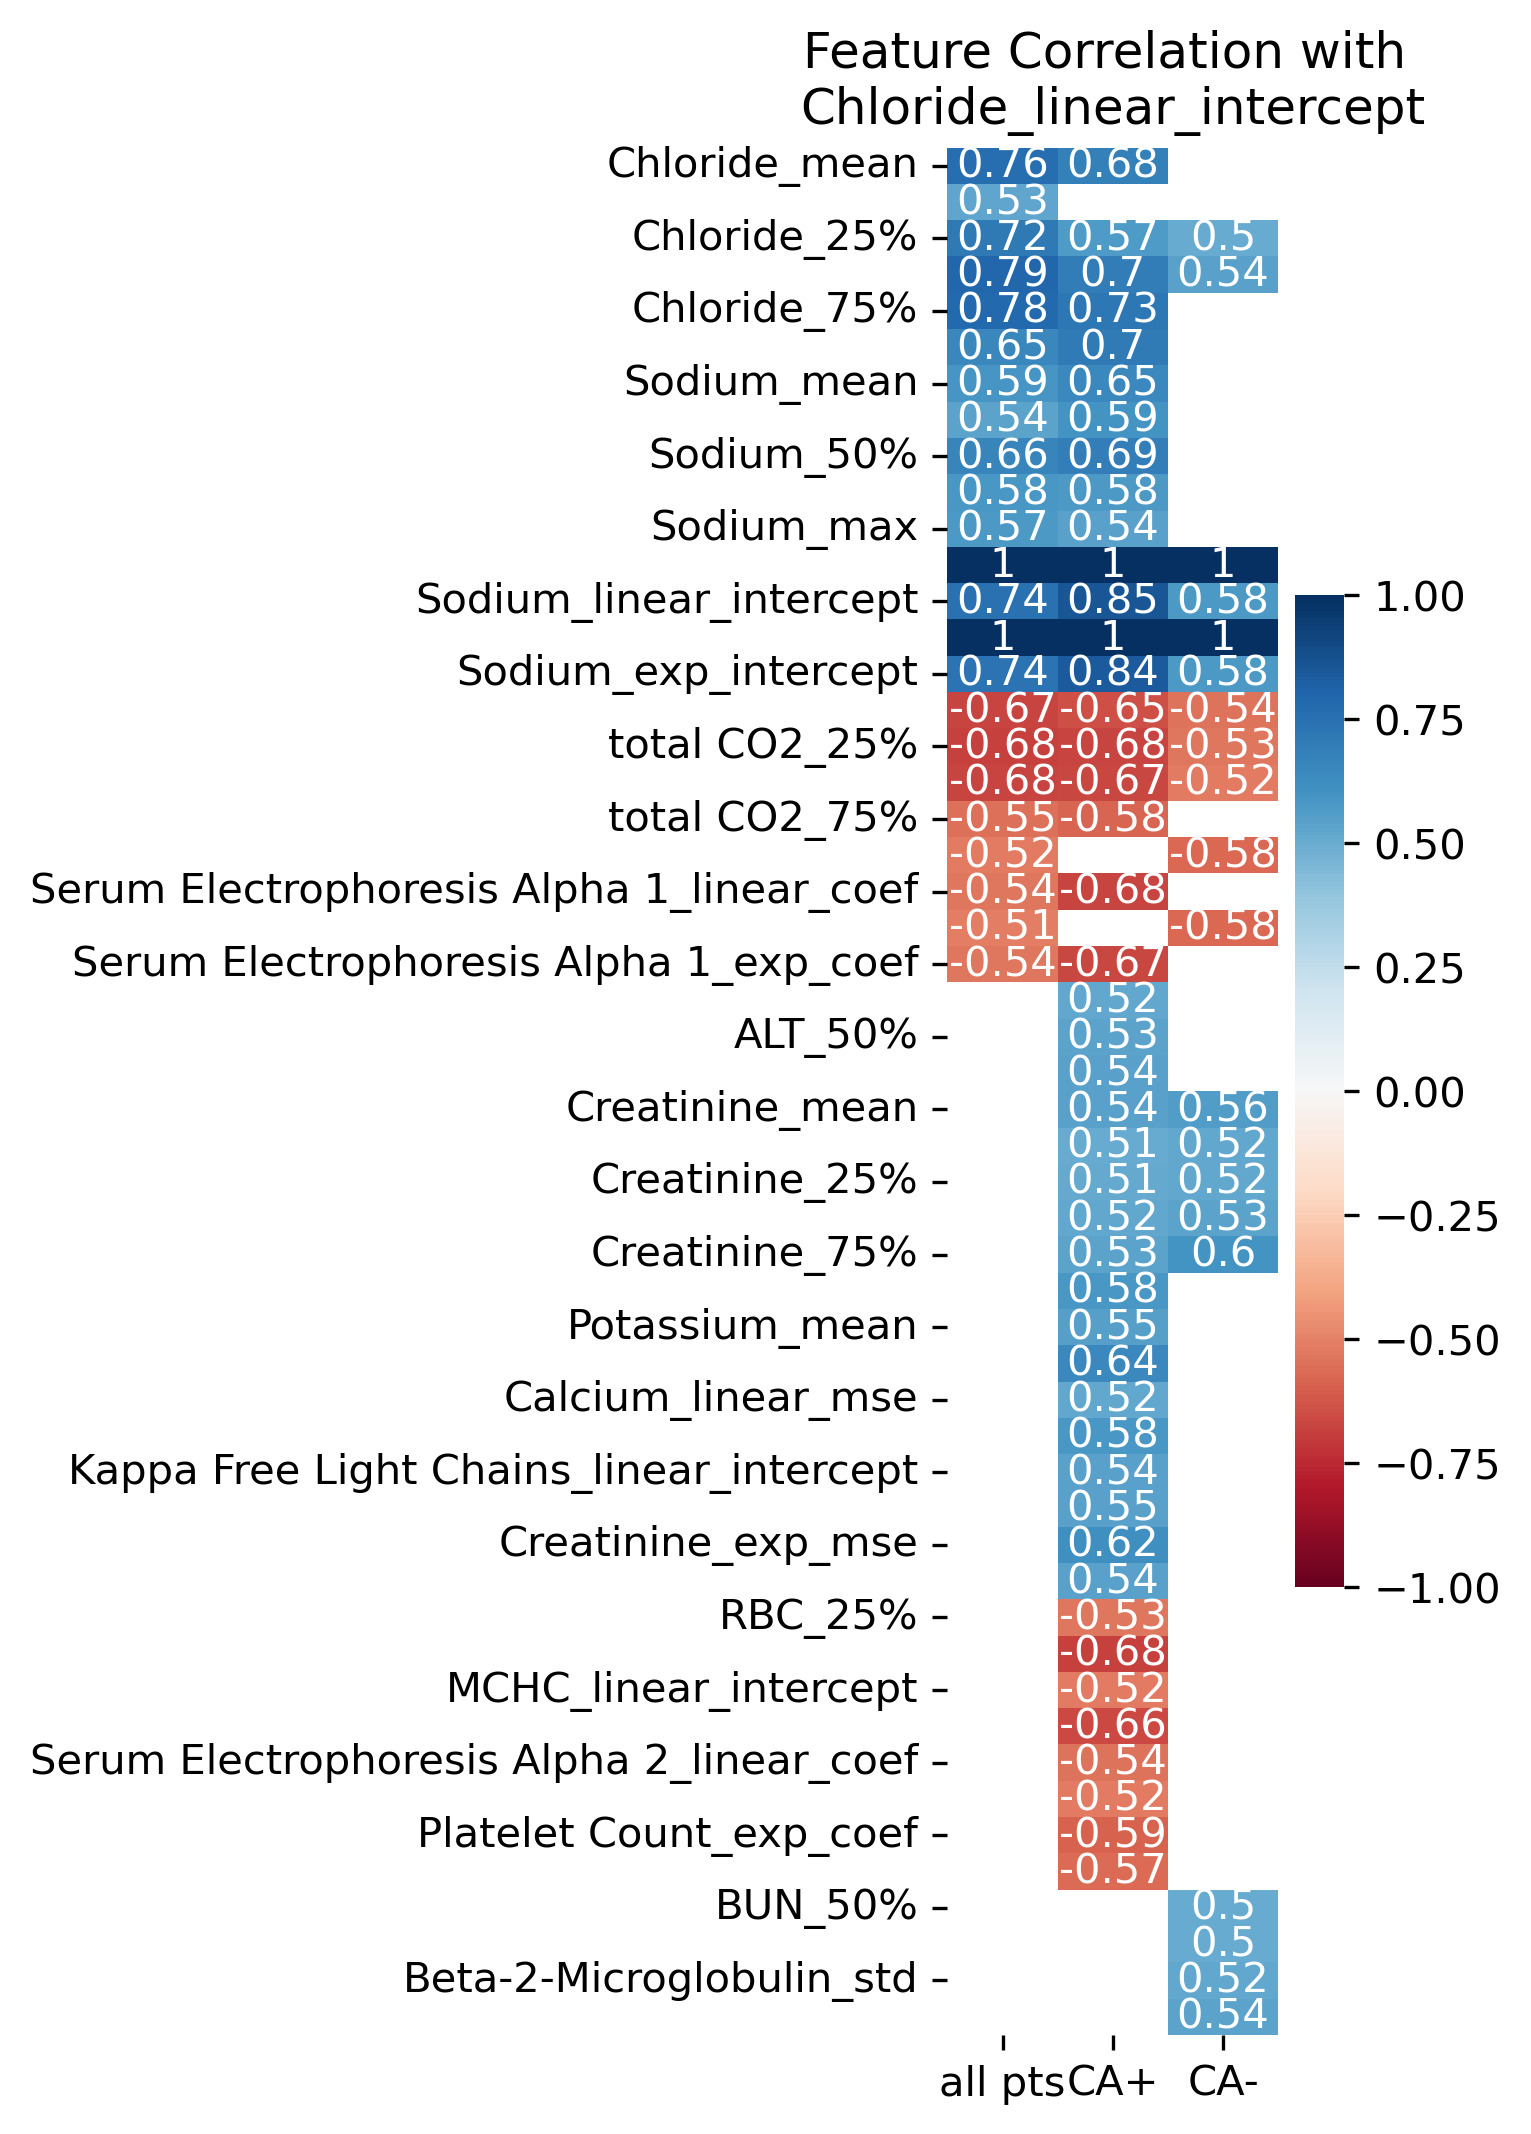

In [160]:
for feature_name in selected_features:
    feat_corr_sig_allpts = pd.concat([feature_correlation[feature_correlation[feature_name]>=0.5][feature_name], 
                                    feature_correlation[feature_correlation[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CApos = pd.concat([feature_correlation_CApositive[feature_correlation_CApositive[feature_name]>=0.5][feature_name], 
                                     feature_correlation_CApositive[feature_correlation_CApositive[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_CAneg = pd.concat([feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]>=0.5][feature_name],
                                     feature_correlation_CAnegative[feature_correlation_CAnegative[feature_name]<=-0.5][feature_name]], axis = 0)

    feat_corr_sig_concat = pd.concat([feat_corr_sig_allpts,feat_corr_sig_CApos,feat_corr_sig_CAneg], axis = 1)
    feat_corr_sig_concat.columns = ['all pts', 'CA+', 'CA-']

    outputToExcel(df_data = feat_corr_sig_concat, fileName_header= "featureCorr_", fileName_Common= fileName_common, fileName_suffix= fileName_suffix ,
                       parent_dir= saving_dirrectory, folderName=makingFolder, sheetName=feature_name.replace("%", "").replace("/",""))

    fig, ax = plt.subplots(figsize = (5,7),layout = 'constrained')
    sns.heatmap(feat_corr_sig_concat, cmap= colormap, vmin= -1, vmax = 1, center = 0, annot = True, ax = ax)
    ax.set_title("Feature Correlation with \n"+ str(feature_name))

    figCommon =feature_name.replace("%", "").replace("/","") + "_heatmap_"
    # fig_file_out = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                         fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out)
    # fig.savefig(fig_file_out, bbox_inches = 'tight')
    # fig_file_out_jpg = ptFn.outputFiguresPath(fileName_header="", fileName_mid=figCommon, 
    #                 fileName_suff= fileNameSuffix, parent_dir=parent_dir, folderName=folder_data_out, fileExtension= '.jpg')
    # fig.savefig(fig_file_out_jpg, bbox_inches = 'tight')